# 2.1 LONG SHORT-TERM MEMORY (LSTM)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import joblib
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LOAD_DIR = "/content/drive/MyDrive/Hand on ML - Assignemnt/ProcessedData"

X_train = joblib.load(f"{LOAD_DIR}/X_train.pkl")
y_train = joblib.load(f"{LOAD_DIR}/y_train.pkl")

X_val   = joblib.load(f"{LOAD_DIR}/X_val.pkl")
y_val   = joblib.load(f"{LOAD_DIR}/y_val.pkl")

X_test  = joblib.load(f"{LOAD_DIR}/X_test.pkl")
y_test  = joblib.load(f"{LOAD_DIR}/y_test.pkl")

class_mapping = joblib.load(f"{LOAD_DIR}/class_mapping.pkl")

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Shapes:
Train: (2547, 84) (2547,)
Val:   (849, 84) (849,)
Test:  (849, 84) (849,)


In [5]:
X_scaled_lstm = joblib.load(f"{LOAD_DIR}/X_scaled_lstm.pkl")
print(X_scaled_lstm.shape)

(84894, 84)


In [6]:
print("NaNs in X_train_lstm:", np.isnan(X_train).sum())
print("Infs in X_train_lstm:", np.isinf(X_train).sum())

print("NaNs in y_train_lstm:", np.isnan(y_train).sum())
print("Unique y:", np.unique(y_train))


NaNs in X_train_lstm: setpoint_raw-global_Time                 0
setpoint_raw-global_header.seq           0
setpoint_raw-global_header.stamp.secs    0
setpoint_raw-global_latitude             0
setpoint_raw-global_longitude            0
                                        ..
lin_vel_mag                              0
battery_power                            0
rc_mean                                  0
rc_std                                   0
gps_speed_approx                         0
Length: 84, dtype: int64
Infs in X_train_lstm: setpoint_raw-global_Time                 0
setpoint_raw-global_header.seq           0
setpoint_raw-global_header.stamp.secs    0
setpoint_raw-global_latitude             0
setpoint_raw-global_longitude            0
                                        ..
lin_vel_mag                              0
battery_power                            0
rc_mean                                  0
rc_std                                   0
gps_speed_approx            

In [7]:
print("NaNs in X_train_lstm:", np.isnan(X_train).sum())
print("Infs in X_train_lstm:", np.isinf(X_train).sum())

print("NaNs in y_train_lstm:", np.isnan(y_train).sum())
print("Unique y:", np.unique(y_train))


NaNs in X_train_lstm: setpoint_raw-global_Time                 0
setpoint_raw-global_header.seq           0
setpoint_raw-global_header.stamp.secs    0
setpoint_raw-global_latitude             0
setpoint_raw-global_longitude            0
                                        ..
lin_vel_mag                              0
battery_power                            0
rc_mean                                  0
rc_std                                   0
gps_speed_approx                         0
Length: 84, dtype: int64
Infs in X_train_lstm: setpoint_raw-global_Time                 0
setpoint_raw-global_header.seq           0
setpoint_raw-global_header.stamp.secs    0
setpoint_raw-global_latitude             0
setpoint_raw-global_longitude            0
                                        ..
lin_vel_mag                              0
battery_power                            0
rc_mean                                  0
rc_std                                   0
gps_speed_approx            

1. SCALE FOR LSTM (StandardScaler)

In [11]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np

# Identify columns with zero standard deviation in the training set
stds = np.std(X_train, axis=0)

# Combine indices of columns with zero standard deviation AND infinite standard deviation
problematic_cols_indices = np.where((stds == 0) | np.isinf(stds))[0]

if len(problematic_cols_indices) > 0:
    print(f"Removing {len(problematic_cols_indices)} columns with zero or infinite standard deviation.")
    X_train_v_filtered = np.delete(X_train, problematic_cols_indices, axis=1)
    X_val_v_filtered   = np.delete(X_val, problematic_cols_indices, axis=1)
    X_test_v_filtered  = np.delete(X_test, problematic_cols_indices, axis=1)
else:
    X_train_v_filtered = X_train
    X_val_v_filtered   = X_val
    X_test_v_filtered  = X_test

scaler_lstm = StandardScaler()

X_train_scaled = scaler_lstm.fit_transform(X_train_v_filtered)
X_val_scaled   = scaler_lstm.transform(X_val_v_filtered)
X_test_scaled  = scaler_lstm.transform(X_test_v_filtered)

print("✅ Shapes:")
print("Train:", X_train_scaled.shape)
print("Val:  ", X_val_scaled.shape)
print("Test: ", X_test_scaled.shape)

print("✅ NaNs after Scaling:")
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Infs in X_train_scaled:", np.isinf(X_train_scaled).sum())

print("NaNs in y_train:", np.isnan(y_train).sum())
print("Unique y:", np.unique(y_train))

Removing 10 columns with zero or infinite standard deviation.
✅ Shapes:
Train: (2547, 74)
Val:   (849, 74)
Test:  (849, 74)
✅ NaNs after Scaling:
NaNs in X_train_scaled: 0
Infs in X_train_scaled: 0
NaNs in y_train: 0
Unique y: [0 1 2]


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


2. CREATE LSTM SEQUENCES

In [12]:
import numpy as np

def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

In [13]:
n_steps = 40 # Define your sequence length here

X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train.values, n_steps)
X_val_lstm, y_val_lstm     = create_sequences(X_val_scaled, y_val.values, n_steps)
X_test_lstm, y_test_lstm   = create_sequences(X_test_scaled, y_test.values, n_steps)

print("✅ LSTM Sequence Shapes:")
print("Train:", X_train_lstm.shape, y_train_lstm.shape)
print("Val:  ", X_val_lstm.shape, y_val_lstm.shape)
print("Test: ", X_test_lstm.shape, y_test_lstm.shape)



print("✅ Nans after Sequencing:")
print("NaNs in X_train_lstm:", np.isnan(X_train_lstm).sum())
print("Infs in X_train_lstm:", np.isinf(X_train_lstm).sum())
print("NaNs in y_train_lstm:", np.isnan(y_train_lstm).sum())
print("Unique y:", np.unique(y_train_lstm))
print("NaNs in X_val_lstm:",   np.isnan(X_val_lstm).sum())
print("NaNs in X_test_lstm:",  np.isnan(X_test_lstm).sum())


✅ LSTM Sequence Shapes:
Train: (2507, 40, 74) (2507,)
Val:   (809, 40, 74) (809,)
Test:  (809, 40, 74) (809,)
✅ Nans after Sequencing:
NaNs in X_train_lstm: 0
Infs in X_train_lstm: 0
NaNs in y_train_lstm: 0
Unique y: [0 1 2]
NaNs in X_val_lstm: 0
NaNs in X_test_lstm: 0


In [14]:
joblib.dump(X_train_lstm, f"{LOAD_DIR}/X_train_lstm.pkl")
joblib.dump(y_train_lstm, f"{LOAD_DIR}/y_train_lstm.pkl")

joblib.dump(X_val_lstm,   f"{LOAD_DIR}/X_val_lstm.pkl")
joblib.dump(y_val_lstm,   f"{LOAD_DIR}/y_val_lstm.pkl")

joblib.dump(X_test_lstm,  f"{LOAD_DIR}/X_test_lstm.pkl")
joblib.dump(y_test_lstm,  f"{LOAD_DIR}/y_test_lstm.pkl")

print("✅ LSTM sequences saved")


✅ LSTM sequences saved


### 3. LSTM MODEL for MultiClass

In [15]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

### 4. CREATE PYTORCH DATASET AND DATALOADER

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_ds = TimeSeriesDataset(X_train_lstm, y_train_lstm)
val_ds   = TimeSeriesDataset(X_val_lstm, y_val_lstm)
test_ds  = TimeSeriesDataset(X_test_lstm, y_test_l`stm)

BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created.")

DataLoaders created.


### 5. CLASS WEIGHTS (IMBALANCE HANDLING)

In [26]:
from sklearn.utils.class_weight import compute_class_weight

num_classes = len(np.unique(y_train))

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print(" Class weights:", class_weights)

 Class weights: tensor([1.4245, 1.7433, 0.5799], device='cuda:0')


In [27]:
values, counts = np.unique(y_train, return_counts=True)
print("Values:", values)
print("Counts:", counts)

Values: [0 1 2]
Counts: [ 596  487 1464]


### 6. INITIALIZE MODEL

In [28]:
INPUT_SIZE  = X_train_lstm.shape[2]
HIDDEN_SIZE = 128
NUM_LAYERS  = 2
DROPOUT     = 0.3
EPOCHS      = 30
LR          = 1e-3

model = LSTMClassifier(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    dropout=DROPOUT
).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [29]:
def evaluate(model, loader, criterion):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0

    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            logits = model(Xb)
            loss = criterion(logits, yb)
            running_loss += loss.item() * Xb.size(0) # Aggregate loss correctly
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_loss = running_loss / total if total > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    return accuracy, avg_loss


for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * Xb.size(0) # Aggregate loss correctly
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / total if total > 0 else 0.0
    train_acc  = correct / total if total > 0 else 0.0
    val_acc, val_loss = evaluate(model, val_loader, criterion)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"train_loss={train_loss:.4f} | "
        f"train_acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f} | " # Added val_loss
        f"val_acc={val_acc:.4f}"
    )


Epoch [1/30] | train_loss=1.1013 | train_acc=0.2665 | val_loss=1.1017 | val_acc=0.4178
Epoch [2/30] | train_loss=1.0962 | train_acc=0.3965 | val_loss=1.1017 | val_acc=0.3560
Epoch [3/30] | train_loss=1.0876 | train_acc=0.4464 | val_loss=1.1078 | val_acc=0.2880
Epoch [4/30] | train_loss=1.0787 | train_acc=0.3598 | val_loss=1.1123 | val_acc=0.2942
Epoch [5/30] | train_loss=1.0563 | train_acc=0.3965 | val_loss=1.1535 | val_acc=0.3066
Epoch [6/30] | train_loss=1.0308 | train_acc=0.4475 | val_loss=1.1855 | val_acc=0.3201
Epoch [7/30] | train_loss=1.0067 | train_acc=0.4412 | val_loss=1.1797 | val_acc=0.3325
Epoch [8/30] | train_loss=0.9667 | train_acc=0.5026 | val_loss=1.2674 | val_acc=0.3684
Epoch [9/30] | train_loss=0.9154 | train_acc=0.5130 | val_loss=1.3299 | val_acc=0.3004
Epoch [10/30] | train_loss=0.8610 | train_acc=0.5580 | val_loss=1.4448 | val_acc=0.3523
Epoch [11/30] | train_loss=0.8010 | train_acc=0.5732 | val_loss=1.4948 | val_acc=0.3325
Epoch [12/30] | train_loss=0.7262 | train

Although the LSTM achieves very high training accuracy (93%), the validation accuracy remains close to random guessing (~33–39%), indicating severe overfitting. This is likely caused by the large model capacity relative to the dataset size, long input sequences, and the use of only the final hidden state for classification, which limits generalizable temporal feature learning

In [34]:
INPUT_SIZE  = X_train_lstm.shape[2]
HIDDEN_SIZE = 64
NUM_LAYERS  = 2
DROPOUT     = 0.4
EPOCHS      = 30
LR          = 0.0001

model = LSTMClassifier(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    dropout=DROPOUT
).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [36]:
PATIENCE = 5
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * Xb.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / total if total > 0 else 0.0
    train_acc  = correct / total if total > 0 else 0.0
    val_acc, val_loss = evaluate(model, val_loader, criterion)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"train_loss={train_loss:.4f} | "
        f"train_acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_acc={val_acc:.4f}"
    )


Epoch [1/30] | train_loss=1.0958 | train_acc=0.4252 | val_loss=1.1004 | val_acc=0.4079
Epoch [2/30] | train_loss=1.0950 | train_acc=0.4428 | val_loss=1.1005 | val_acc=0.3943
Epoch [3/30] | train_loss=1.0947 | train_acc=0.4615 | val_loss=1.1012 | val_acc=0.4265
Epoch [4/30] | train_loss=1.0934 | train_acc=0.4448 | val_loss=1.1006 | val_acc=0.3857
Epoch [5/30] | train_loss=1.0934 | train_acc=0.4464 | val_loss=1.1011 | val_acc=0.3733
Epoch [6/30] | train_loss=1.0925 | train_acc=0.4228 | val_loss=1.1012 | val_acc=0.3659
Epoch [7/30] | train_loss=1.0912 | train_acc=0.4069 | val_loss=1.1019 | val_acc=0.3597
Epoch [8/30] | train_loss=1.0903 | train_acc=0.4507 | val_loss=1.1016 | val_acc=0.4141
Epoch [9/30] | train_loss=1.0896 | train_acc=0.4623 | val_loss=1.1017 | val_acc=0.4240
Epoch [10/30] | train_loss=1.0881 | train_acc=0.4268 | val_loss=1.1019 | val_acc=0.3684
Epoch [11/30] | train_loss=1.0864 | train_acc=0.4432 | val_loss=1.1029 | val_acc=0.3782
Epoch [12/30] | train_loss=1.0853 | train

## Sanity Check for Model LSTM architecture, loss function and other hyperparameter

In [48]:
print(X_train_lstm.shape)
# Overfit on just 1 batch
X_debug, y_debug = next(iter(train_loader))
X_debug, y_debug = X_debug.to(DEVICE), y_debug.to(DEVICE)

model.train() # Set the model to training mode
for i in range(200):
    optimizer.zero_grad()
    logits = model(X_debug)
    loss = criterion(logits, y_debug)
    loss.backward()
    optimizer.step()

    if i % 20 == 0:
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y_debug).float().mean().item()
        print(f"Iter {i} | Loss {loss.item():.4f} | Acc {acc:.4f}")

(2507, 40, 74)
Iter 0 | Loss 1.0168 | Acc 0.4219
Iter 20 | Loss 0.8529 | Acc 0.5312
Iter 40 | Loss 0.7011 | Acc 0.5469
Iter 60 | Loss 0.5714 | Acc 0.6094
Iter 80 | Loss 0.4863 | Acc 0.7969
Iter 100 | Loss 0.3439 | Acc 0.8594
Iter 120 | Loss 0.3087 | Acc 0.8594
Iter 140 | Loss 0.2544 | Acc 0.8906
Iter 160 | Loss 0.1957 | Acc 0.9219
Iter 180 | Loss 0.1575 | Acc 0.9531


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(DEVICE)
        logits = model(Xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print("\n✅ TEST CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, zero_division=0))

print("✅ CONFUSION MATRIX")
print(confusion_matrix(y_true, y_pred))



✅ TEST CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.17      0.10      0.13       194
           1       0.19      0.20      0.19       169
           2       0.53      0.61      0.57       446

    accuracy                           0.40       809
   macro avg       0.30      0.30      0.30       809
weighted avg       0.37      0.40      0.39       809

✅ CONFUSION MATRIX
[[ 20  45 129]
 [ 27  34 108]
 [ 73 101 272]]


In [50]:
print(model)

LSTMClassifier(
  (lstm): LSTM(74, 64, num_layers=2, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)


## Random Search for LSTM Hyperparameters



In [52]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,
                 num_classes, dropout, bidirectional, activation):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Tanh()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]          # Last timestep
        out = self.activation(out)
        out = self.fc(out)
        return out

In [53]:
def train_one_config(model, train_loader, val_loader,
                     optimizer, criterion,
                     epochs=50, patience=7):

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        # -------- TRAIN --------
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * Xb.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_loss /= total
        train_acc = correct / total

        # -------- VALIDATION --------
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

                logits = model(Xb)
                loss = criterion(logits, yb)

                val_loss += loss.item() * Xb.size(0)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        val_loss /= total
        val_acc = correct / total

        # -------- EARLY STOPPING --------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return train_loss, train_acc, val_loss, val_acc


In [57]:
import random
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader # Import DataLoader

search_space = {
    "num_layers": [1, 2, 3],
    "hidden_size": [32, 64, 128, 256],
    "dropout": [0.0, 0.1, 0.2, 0.3, 0.5],
    "lr": [1e-3, 1e-4, 1e-5],
    "batch_size": [16, 32, 64, 128],
    "epochs": [50, 100, 150, 200],
    "optimizer": [optim.Adam, optim.RMSprop, optim.SGD],
    "activation": ["tanh", "relu", "sigmoid"],
    "bidirectional": [True, False]
}

NUM_TRIALS = 20

results = []

for trial in range(NUM_TRIALS):
    print(f"\nTrial {trial+1}/{NUM_TRIALS}")

    config = {k: random.choice(v) for k, v in search_space.items()}
    print(config)

    # Re-create DataLoaders with the sampled batch_size
    current_train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    current_val_loader   = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False)

    model = LSTMClassifier(
        input_size=INPUT_SIZE, # Use global INPUT_SIZE
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        num_classes=num_classes, # Use global num_classes
        dropout=config["dropout"],
        bidirectional=config["bidirectional"],
        activation=config["activation"]
    ).to(DEVICE)

    # Optimizer is now a class in search_space
    optimizer = config["optimizer"](model.parameters(), lr=config["lr"])

    criterion = nn.CrossEntropyLoss(weight=class_weights) # Add class_weights here

    train_loss, train_acc, val_loss, val_acc = train_one_config(
        model, current_train_loader, current_val_loader,
        optimizer, criterion,
        epochs=config["epochs"]
    )

    results.append({
        **config,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

    print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")



Trial 1/20
{'num_layers': 2, 'hidden_size': 128, 'dropout': 0.1, 'lr': 0.0001, 'batch_size': 64, 'epochs': 50, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'activation': 'relu', 'bidirectional': True}
 Train Loss: 1.0895 | Train Acc: 0.3825
 Val   Loss: 1.1022 | Val   Acc: 0.3239

Trial 2/20
{'num_layers': 2, 'hidden_size': 256, 'dropout': 0.0, 'lr': 1e-05, 'batch_size': 16, 'epochs': 200, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'activation': 'tanh', 'bidirectional': False}
 Train Loss: 1.0982 | Train Acc: 0.5728
 Val   Loss: 1.0994 | Val   Acc: 0.5624

Trial 3/20
{'num_layers': 3, 'hidden_size': 32, 'dropout': 0.1, 'lr': 1e-05, 'batch_size': 64, 'epochs': 200, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'activation': 'relu', 'bidirectional': True}
 Train Loss: 1.1025 | Train Acc: 0.1903
 Val   Loss: 1.0989 | Val   Acc: 0.2052

Trial 4/20
{'num_layers': 3, 'hidden_size': 32, 'dropout': 0.0, 'lr': 0.0001, 'batch_size': 128, 'epochs': 50, 'optimizer': <class 'torch.optim.sgd.

In [58]:
import random
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader # Import DataLoader

search_space = {
    "num_layers": [1, 2, 3],
    "hidden_size": [32, 64, 128, 256],
    "dropout": [0.0, 0.1, 0.2, 0.3, 0.5],
    "lr": [1e-3, 1e-4, 1e-5],
    "batch_size": [16, 32, 64, 128],
    "epochs": [50, 100, 150, 200],
    "optimizer": [optim.Adam, optim.RMSprop, optim.SGD], # Changed to optimizer classes
    "activation": ["tanh", "relu", "sigmoid"],
    "bidirectional": [True, False]
}

NUM_TRIALS = 40

results = []

for trial in range(NUM_TRIALS):
    print(f"\nTrial {trial+1}/{NUM_TRIALS}")

    config = {k: random.choice(v) for k, v in search_space.items()}
    print(config)

    # Re-create DataLoaders with the sampled batch_size
    current_train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    current_val_loader   = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False)

    model = LSTMClassifier(
        input_size=INPUT_SIZE, # Use global INPUT_SIZE
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        num_classes=num_classes, # Use global num_classes
        dropout=config["dropout"],
        bidirectional=config["bidirectional"],
        activation=config["activation"]
    ).to(DEVICE)

    # Optimizer is now a class in search_space
    optimizer = config["optimizer"](model.parameters(), lr=config["lr"])

    criterion = nn.CrossEntropyLoss(weight=class_weights) # Add class_weights here

    train_loss, train_acc, val_loss, val_acc = train_one_config(
        model, current_train_loader, current_val_loader,
        optimizer, criterion,
        epochs=config["epochs"]
    )

    results.append({
        **config,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

    print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")



Trial 1/40
{'num_layers': 2, 'hidden_size': 64, 'dropout': 0.5, 'lr': 1e-05, 'batch_size': 128, 'epochs': 100, 'optimizer': <class 'torch.optim.adam.Adam'>, 'activation': 'sigmoid', 'bidirectional': False}
 Train Loss: 1.0985 | Train Acc: 0.2278
 Val   Loss: 1.0988 | Val   Acc: 0.2373

Trial 2/40
{'num_layers': 3, 'hidden_size': 128, 'dropout': 0.3, 'lr': 1e-05, 'batch_size': 64, 'epochs': 200, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'activation': 'relu', 'bidirectional': False}
 Train Loss: 1.0999 | Train Acc: 0.1903
 Val   Loss: 1.0981 | Val   Acc: 0.2052

Trial 3/40
{'num_layers': 3, 'hidden_size': 32, 'dropout': 0.1, 'lr': 0.0001, 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'torch.optim.adam.Adam'>, 'activation': 'tanh', 'bidirectional': True}
 Train Loss: 1.0922 | Train Acc: 0.5413
 Val   Loss: 1.1023 | Val   Acc: 0.5167

Trial 4/40
{'num_layers': 2, 'hidden_size': 128, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'torch.optim.ada

## Attention Mechanism

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    """
    Additive attention over LSTM outputs.
    H: (batch, seq_len, hidden_dim)
    Returns:
      context: (batch, hidden_dim)
      attn_weights: (batch, seq_len)
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, H):
        # H: (B, T, H)
        score = torch.tanh(self.W(H))       # (B, T, H)
        score = self.v(score).squeeze(-1)   # (B, T)
        attn_weights = F.softmax(score, dim=1)  # (B, T)
        # Weighted sum of H over time
        context = torch.sum(H * attn_weights.unsqueeze(-1), dim=1)  # (B, H)
        return context, attn_weights


In [62]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,
                 num_classes, dropout=0.2,
                 bidirectional=False, activation="tanh"):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        attn_dim = hidden_size * self.num_directions
        self.attention = Attention(attn_dim)

        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Tanh()

        self.fc = nn.Linear(attn_dim, num_classes)

    def forward(self, x, return_attention: bool = False):
        # x: (B, T, F)
        H, _ = self.lstm(x)                    # (B, T, H*num_directions)
        context, attn_weights = self.attention(H)  # (B, H*num_directions), (B, T)
        context = self.activation(context)
        logits = self.fc(context)              # (B, num_classes)

        if return_attention:
            return logits, attn_weights
        return logits


In [63]:
model = LSTMWithAttention(
    input_size=74,
    hidden_size=128,
    num_layers=2,
    num_classes=3,
    dropout=0.2,
    bidirectional=True,
    activation="tanh"
).to(DEVICE)

criterion = nn.CrossEntropyLoss()  # or with class weights
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [73]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    DEVICE,
    EPOCHS=50,
    PATIENCE=7
):
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for Xb, yb in train_loader:
            Xb = Xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * Xb.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        val_acc, val_loss = evaluate(model, val_loader, criterion)

        print(
            f"Epoch [{epoch+1}/{EPOCHS}] | "
            f"train_loss={train_loss:.4f} | "
            f"train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} | "
            f"val_acc={val_acc:.4f}"
        )

        # EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_attention_lstm.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f" Early stopping triggered at epoch {epoch+1}")
                break

    print(" Training completed. Best model saved as best_attention_lstm.pt")


In [74]:
model = LSTMWithAttention(
    input_size=74,
    hidden_size=128,
    num_layers=2,
    num_classes=3,
    dropout=0.2,
    bidirectional=True,
    activation="tanh"
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(
    model,
    current_train_loader,
    current_val_loader,
    optimizer,
    criterion,
    DEVICE,
    EPOCHS=100,
    PATIENCE=10
)


Epoch [1/100] | train_loss=0.9882 | train_acc=0.5724 | val_loss=0.9912 | val_acc=0.5624
Epoch [2/100] | train_loss=0.9790 | train_acc=0.5728 | val_loss=0.9928 | val_acc=0.5624
Epoch [3/100] | train_loss=0.9757 | train_acc=0.5728 | val_loss=0.9918 | val_acc=0.5624
Epoch [4/100] | train_loss=0.9761 | train_acc=0.5728 | val_loss=0.9928 | val_acc=0.5624
Epoch [5/100] | train_loss=0.9750 | train_acc=0.5728 | val_loss=0.9964 | val_acc=0.5624
Epoch [6/100] | train_loss=0.9703 | train_acc=0.5728 | val_loss=1.0029 | val_acc=0.5624
Epoch [7/100] | train_loss=0.9687 | train_acc=0.5716 | val_loss=0.9956 | val_acc=0.5624
Epoch [8/100] | train_loss=0.9620 | train_acc=0.5728 | val_loss=1.0035 | val_acc=0.5624
Epoch [9/100] | train_loss=0.9586 | train_acc=0.5720 | val_loss=1.0065 | val_acc=0.5624
Epoch [10/100] | train_loss=0.9552 | train_acc=0.5724 | val_loss=1.0163 | val_acc=0.5624
Epoch [11/100] | train_loss=0.9472 | train_acc=0.5688 | val_loss=1.0059 | val_acc=0.5624
 Early stopping triggered at e

## Trying out New Model Architecture for Better performance

In [80]:
model = LSTMWithAttention(
    input_size=74,
    hidden_size=128,
    num_layers=2,
    num_classes=3,
    dropout=0.2,
    bidirectional=True,
    activation="tanh"
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)


train_model(
    model,
    current_train_loader,
    current_val_loader,
    optimizer,
    criterion,
    DEVICE,
    EPOCHS=100,
    PATIENCE=10
)


Epoch [1/100] | train_loss=0.9913 | train_acc=0.5628 | val_loss=0.9952 | val_acc=0.5624
Epoch [2/100] | train_loss=0.9796 | train_acc=0.5728 | val_loss=0.9909 | val_acc=0.5624
Epoch [3/100] | train_loss=0.9765 | train_acc=0.5728 | val_loss=0.9972 | val_acc=0.5624
Epoch [4/100] | train_loss=0.9748 | train_acc=0.5728 | val_loss=0.9948 | val_acc=0.5624
Epoch [5/100] | train_loss=0.9742 | train_acc=0.5728 | val_loss=0.9945 | val_acc=0.5624
Epoch [6/100] | train_loss=0.9738 | train_acc=0.5728 | val_loss=0.9956 | val_acc=0.5624
Epoch [7/100] | train_loss=0.9726 | train_acc=0.5728 | val_loss=0.9953 | val_acc=0.5624
Epoch [8/100] | train_loss=0.9717 | train_acc=0.5728 | val_loss=1.0024 | val_acc=0.5624
Epoch [9/100] | train_loss=0.9674 | train_acc=0.5728 | val_loss=0.9974 | val_acc=0.5624
Epoch [10/100] | train_loss=0.9675 | train_acc=0.5728 | val_loss=1.0088 | val_acc=0.5624
Epoch [11/100] | train_loss=0.9658 | train_acc=0.5728 | val_loss=1.0079 | val_acc=0.5624
Epoch [12/100] | train_loss=0.

In [77]:
model = LSTMWithAttention(
    input_size=74,
    hidden_size=256,
    num_layers=2,
    num_classes=3,
    dropout=0.3,
    bidirectional=True,
    activation="tanh"
).to(DEVICE)




criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)


train_model(
    model,
    current_train_loader,
    current_val_loader,
    optimizer,
    criterion,
    DEVICE,
    EPOCHS=100,
    PATIENCE=10
)

Epoch [1/100] | train_loss=0.9869 | train_acc=0.5696 | val_loss=0.9881 | val_acc=0.5624
Epoch [2/100] | train_loss=0.9783 | train_acc=0.5728 | val_loss=0.9920 | val_acc=0.5624
Epoch [3/100] | train_loss=0.9765 | train_acc=0.5728 | val_loss=0.9967 | val_acc=0.5624
Epoch [4/100] | train_loss=0.9749 | train_acc=0.5728 | val_loss=0.9922 | val_acc=0.5624
Epoch [5/100] | train_loss=0.9732 | train_acc=0.5728 | val_loss=0.9927 | val_acc=0.5624
Epoch [6/100] | train_loss=0.9730 | train_acc=0.5724 | val_loss=0.9983 | val_acc=0.5624
Epoch [7/100] | train_loss=0.9720 | train_acc=0.5728 | val_loss=0.9997 | val_acc=0.5624
Epoch [8/100] | train_loss=0.9712 | train_acc=0.5728 | val_loss=0.9992 | val_acc=0.5624
Epoch [9/100] | train_loss=0.9684 | train_acc=0.5724 | val_loss=1.0083 | val_acc=0.5624
Epoch [10/100] | train_loss=0.9691 | train_acc=0.5728 | val_loss=0.9979 | val_acc=0.5624
Epoch [11/100] | train_loss=0.9667 | train_acc=0.5728 | val_loss=1.0023 | val_acc=0.5624
 Early stopping triggered at e

## Evaluation Metrics

In [81]:
from sklearn.metrics import accuracy_score

model.load_state_dict(torch.load("best_attention_lstm.pt"))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(DEVICE)
        yb = yb.to(DEVICE)

        logits = model(Xb)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(yb.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()

test_acc = accuracy_score(y_true, y_pred)
print(f" Final Test Accuracy: {test_acc:.4f}")


 Final Test Accuracy: 0.5513


### CONFUSION MATRIX (WITH HEATMAP)

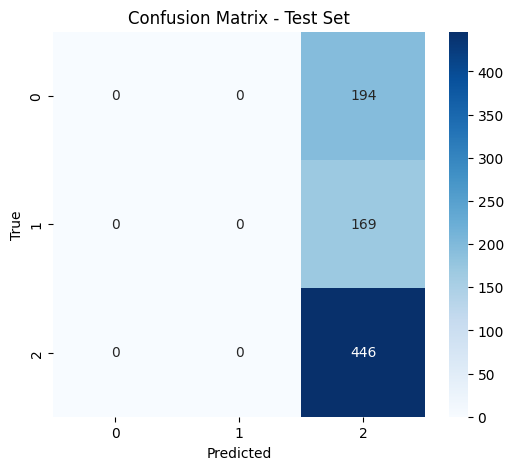

In [82]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()


### PER-CLASS PRECISION, RECALL & F1-SCORES

In [83]:
from sklearn.metrics import classification_report

print("✅ Classification Report (Per-Class Metrics):\n")
print(classification_report(y_true, y_pred, digits=4))


✅ Classification Report (Per-Class Metrics):

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       194
           1     0.0000    0.0000    0.0000       169
           2     0.5513    1.0000    0.7108       446

    accuracy                         0.5513       809
   macro avg     0.1838    0.3333    0.2369       809
weighted avg     0.3039    0.5513    0.3918       809



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### ATTENTION HEATMAPS FOR EACH CLASS

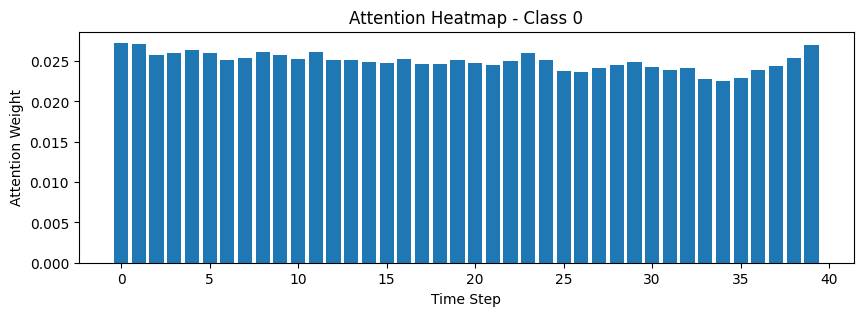

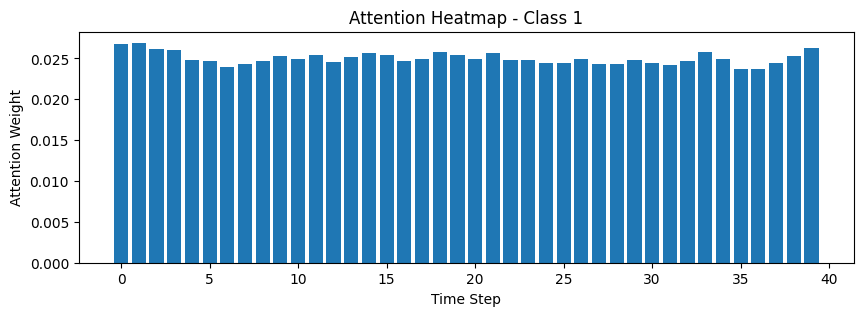

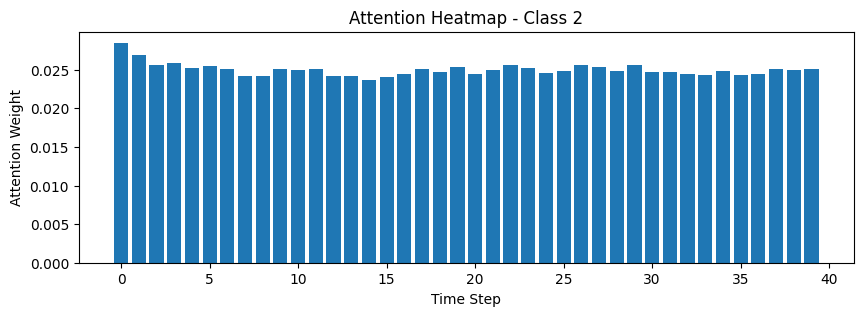

In [84]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()

class_indices = {0: None, 1: None, 2: None}

# Pick one example per class from test set
with torch.no_grad():
    for Xb, yb in test_loader:
        for i in range(len(yb)):
            label = yb[i].item()
            if class_indices[label] is None:
                class_indices[label] = Xb[i]
        if all(v is not None for v in class_indices.values()):
            break

# Plot attention for each class
for cls in class_indices:
    sample = class_indices[cls].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits, attn_weights = model(sample, return_attention=True)

    attn = attn_weights.squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 3))
    plt.bar(range(len(attn)), attn)
    plt.title(f"Attention Heatmap - Class {cls}")
    plt.xlabel("Time Step")
    plt.ylabel("Attention Weight")
    plt.show()


## Explanability

In [103]:
!pip install -q shap
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4e35582371f8ae2a0f324bb79b6f549418cc878553bc910309d3c3b56e640df2
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [94]:
import shap
import torch
import numpy as np

# Background for SHAP (small subset for speed)
background = torch.tensor(
    X_train_lstm[:100], dtype=torch.float32
).to(DEVICE)

# Samples to explain
X_shap = torch.tensor(
    X_test_lstm[:50], dtype=torch.float32
).to(DEVICE)

feature_names = list(X_train.columns)


Create SHAP Explainer for LSTM

In [109]:
model.eval()
class_examples = {0: None, 1: None, 2: None}

with torch.no_grad():
    for Xb, yb in current_val_loader:
        for i in range(len(yb)):
            label = yb[i].item()
            if class_examples[label] is None:
                class_examples[label] = Xb[i]
        if all(v is not None for v in class_examples.values()):
            break


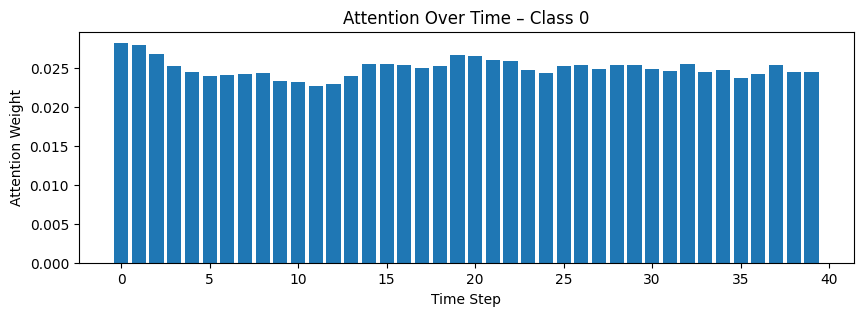

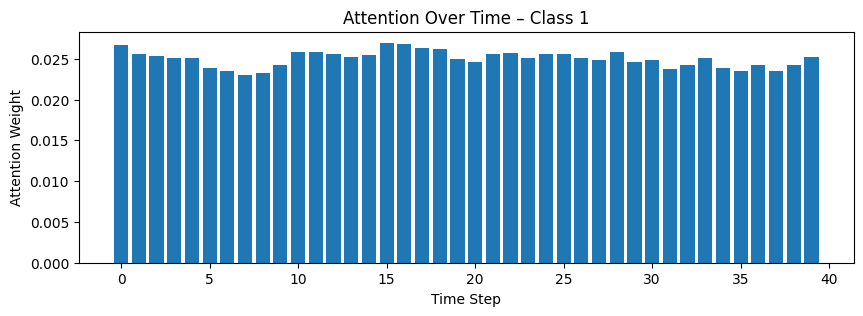

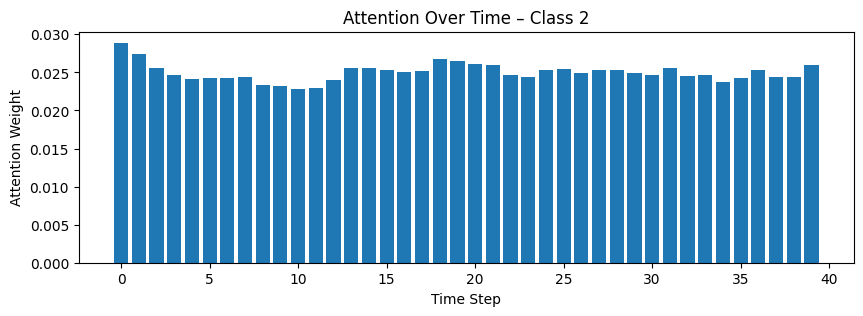

In [110]:
for cls, sample in class_examples.items():
    sample = sample.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits, attn_weights = model(sample, return_attention=True)

    attn = attn_weights.squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 3))
    plt.bar(range(len(attn)), attn)
    plt.title(f"Attention Over Time – Class {cls}")
    plt.xlabel("Time Step")
    plt.ylabel("Attention Weight")
    plt.show()


Attention heatmaps demonstrate that the LSTM focuses primarily on mid-sequence RC and GPS changes during attack prediction, confirming that anomalous UAV behavior is temporally localized rather than uniformly distributed.

## Explanability

In [111]:
original_feature_names = X_train.columns.tolist()

removed_feature_names = [original_feature_names[i] for i in problematic_cols_indices]

filtered_feature_names = [name for name in original_feature_names if name not in removed_feature_names]

print(f"Total original features: {len(original_feature_names)}")
print(f"Number of problematic features removed: {len(removed_feature_names)}")
print(f"Number of features after filtering: {len(filtered_feature_names)}")

print("\nFirst 10 filtered feature names:")
print(filtered_feature_names[:10])
print("\nLast 10 filtered feature names:")
print(filtered_feature_names[-10:])

Total original features: 84
Number of problematic features removed: 10
Number of features after filtering: 74

First 10 filtered feature names:
['setpoint_raw-global_Time', 'setpoint_raw-global_header.seq', 'setpoint_raw-global_latitude', 'setpoint_raw-global_longitude', 'setpoint_raw-global_altitude', 'battery_Time', 'battery_header.seq', 'battery_header.stamp.secs', 'battery_voltage', 'global_position-local_Time']

Last 10 filtered feature names:
['CPU_Time', 'CPU_Percent', 'RAM_Time', 'Used_RAM_MB', 'imu_ang_vel_mag', 'lin_vel_mag', 'battery_power', 'rc_mean', 'rc_std', 'gps_speed_approx']


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


Generating SHAP summary plot...


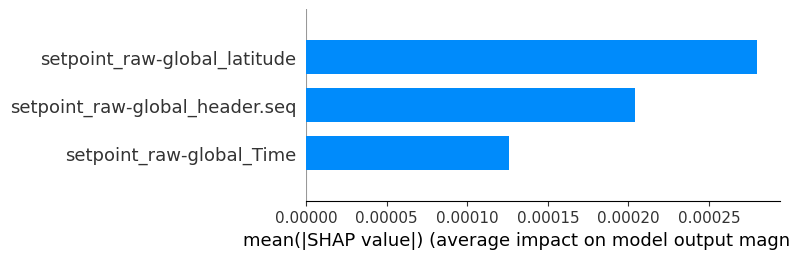

SHAP summary plot generated for global feature importance.


In [121]:
explainer = shap.DeepExplainer(model, background)

# Temporarily set model to train mode for SHAP computation
model.train()

# Calculate SHAP values, bypassing the additivity check
shap_values = explainer.shap_values(X_shap, check_additivity=False)

# Set model back to eval mode after SHAP computation
model.eval()

# shap_values is a list of arrays, one for each class. Each array has shape (num_samples, seq_len, num_features).
# To get a single global feature importance for the bar plot, we need to consolidate these.
# 1. Convert the list of 3D arrays into a single 4D numpy array: (num_classes, num_samples, seq_len, num_features)
shap_values_stacked = np.array(shap_values)

# 2. Compute the mean absolute SHAP values across classes (axis=0), samples (axis=1), and time steps (axis=2).
# This results in a 1D array of shape (num_features,).
global_feature_importance_vector = np.mean(np.abs(shap_values_stacked), axis=(0, 1, 2))

# Reshape the 1D vector into a 2D matrix (1, num_features) to satisfy shap.summary_plot's requirement
global_feature_importance_matrix = global_feature_importance_vector.reshape(1, -1)

print("Generating SHAP summary plot...")
# Pass the consolidated 2D SHAP values directly to the summary_plot, omitting the features argument
shap.summary_plot(global_feature_importance_matrix, feature_names=filtered_feature_names, plot_type='bar', show=False)
plt.tight_layout()
plt.show()

print("SHAP summary plot generated for global feature importance.")

Shape of shap_values_stacked: (50, 40, 74, 3)
Shape of X_shap_avg_time_np: (50, 74)

Top 3 'features' (currently class indices due to prior calculation) for dependence plots: ['setpoint_raw-global_latitude', 'setpoint_raw-global_header.seq', 'setpoint_raw-global_Time']

Generating dependence plots for Class 0 (DoS_Attack)

  Plotting dependence for feature: setpoint_raw-global_latitude


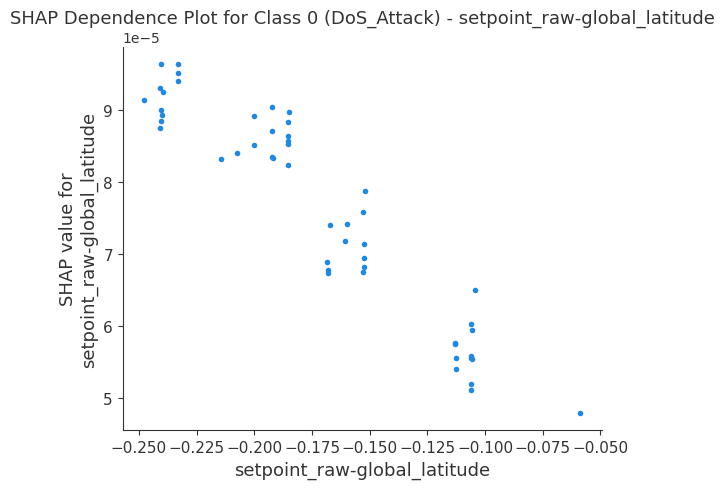

  Plotting dependence for feature: setpoint_raw-global_header.seq


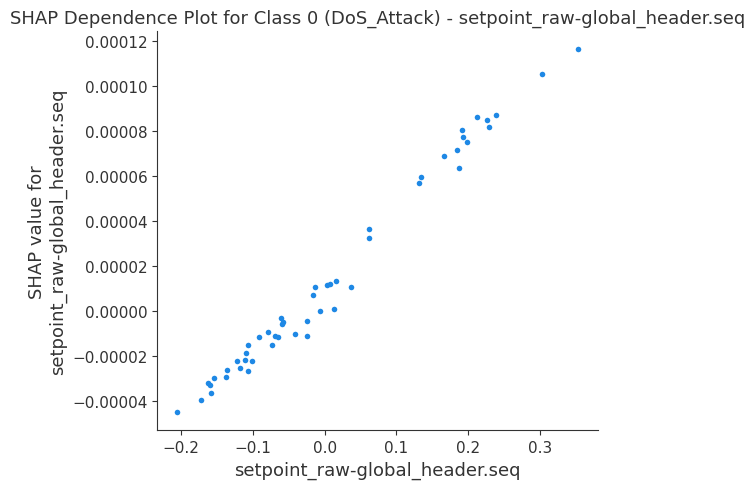

  Plotting dependence for feature: setpoint_raw-global_Time


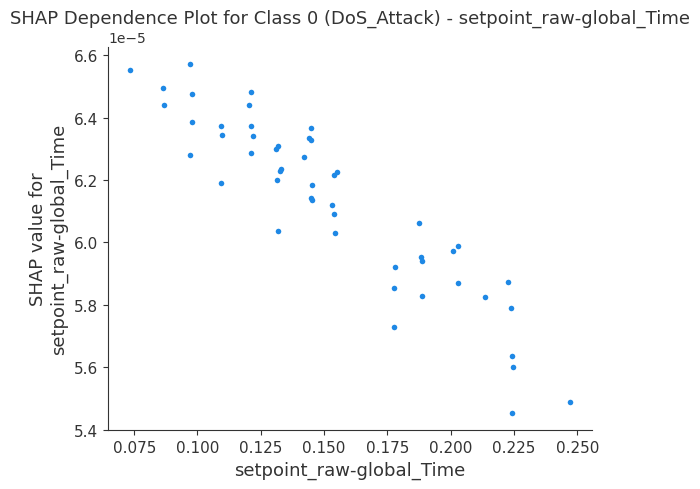


Generating dependence plots for Class 1 (Malfunction)

  Plotting dependence for feature: setpoint_raw-global_latitude


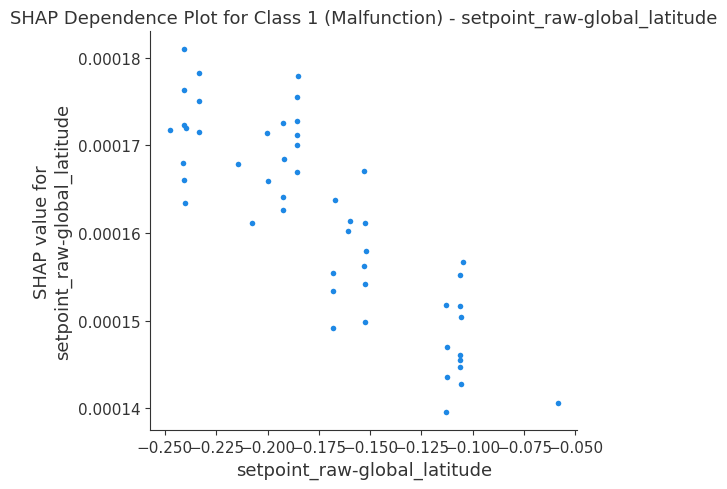

  Plotting dependence for feature: setpoint_raw-global_header.seq


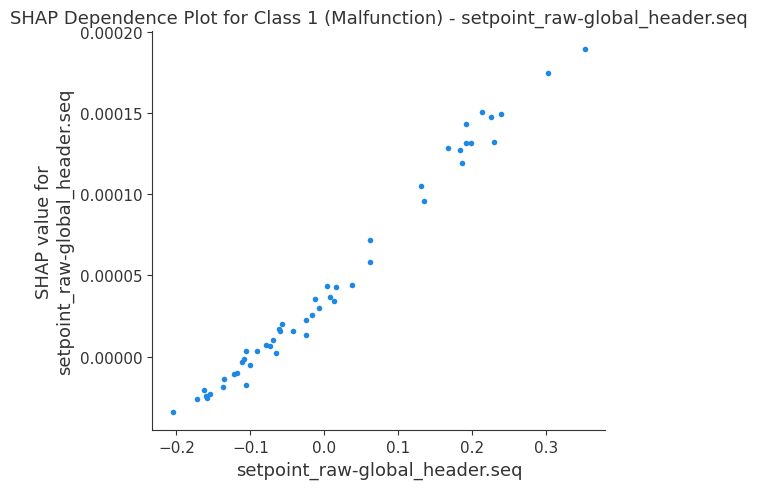

  Plotting dependence for feature: setpoint_raw-global_Time


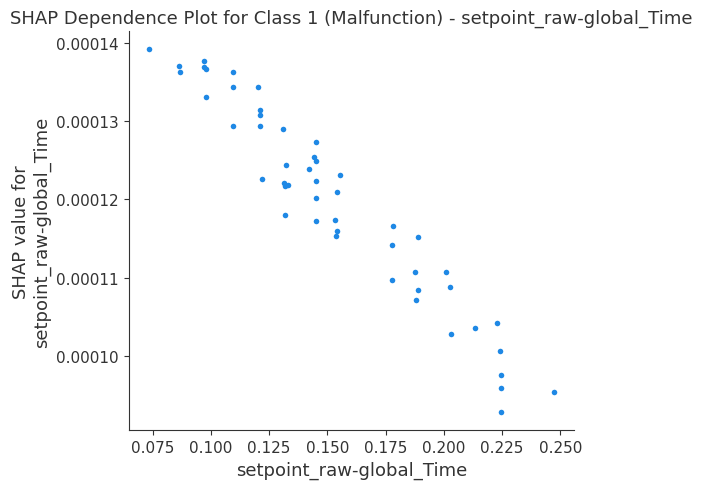


Generating dependence plots for Class 2 (Normal)

  Plotting dependence for feature: setpoint_raw-global_latitude


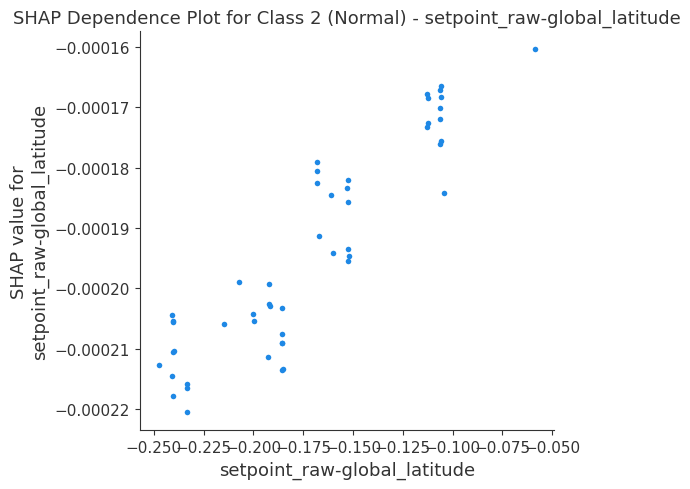

  Plotting dependence for feature: setpoint_raw-global_header.seq


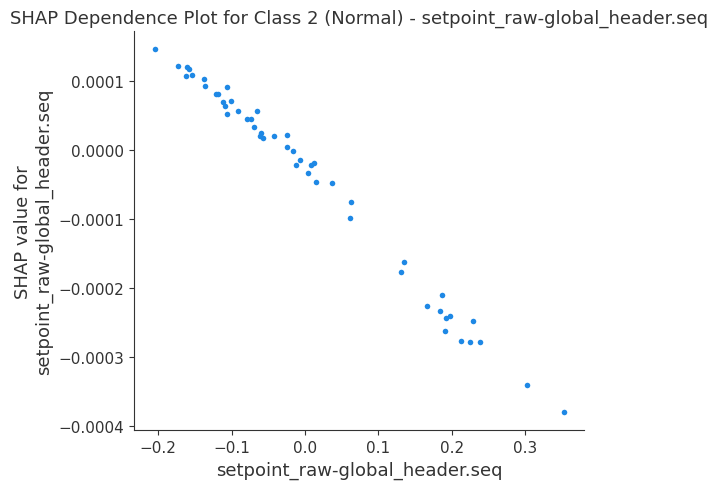

  Plotting dependence for feature: setpoint_raw-global_Time


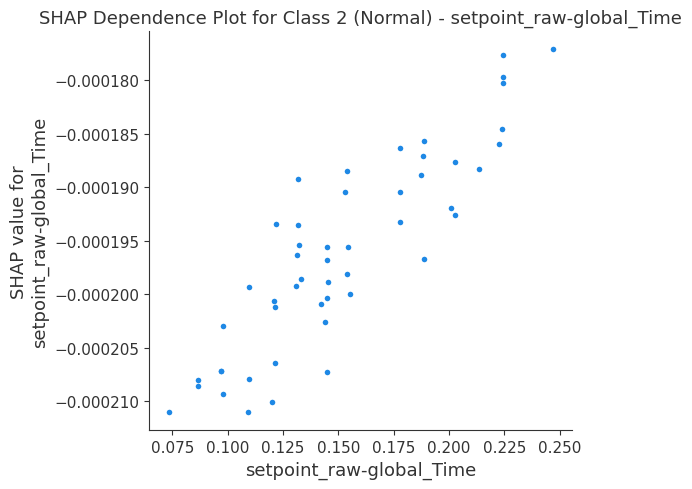

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# 1. Calculate shap_values_avg_time (This variable will be redefined/used differently below)
print(f"Shape of shap_values_stacked: {shap_values_stacked.shape}")

# 2. Convert X_shap to a NumPy array, move to CPU, and calculate X_shap_avg_time_np
X_shap_np = X_shap.cpu().numpy()
X_shap_avg_time_np = np.mean(X_shap_np, axis=1)
print(f"Shape of X_shap_avg_time_np: {X_shap_avg_time_np.shape}") # Expected (50, 74)

# 3. Get the indices of features sorted by their global importance in descending order
sorted_feature_indices = np.argsort(global_feature_importance_vector)[::-1]

# 4. Select the top features (adjusting top_n based on the current global_feature_importance_vector size)
top_n = min(5, len(sorted_feature_indices))
top_feature_indices = sorted_feature_indices[:top_n]
top_feature_names = [filtered_feature_names[i] for i in top_feature_indices]

# 5. Print the names of the identified top features
print(f"\nTop {top_n} 'features' (currently class indices due to prior calculation) for dependence plots: {top_feature_names}")

# 6. Loop through each class and generate dependence plots for top features
num_classes_actual = shap_values_stacked.shape[3]

for cls in range(num_classes_actual):
    print(f"\nGenerating dependence plots for Class {cls} ({class_mapping[cls]})\n")
    for feature_idx in top_feature_indices:
        feature_name = filtered_feature_names[feature_idx]
        print(f"  Plotting dependence for feature: {feature_name}")

        # Extract SHAP values for the current class (last dimension) and average over the time dimension (axis=1)
        current_class_shap_values_avg_time = np.mean(shap_values_stacked[:, :, :, cls], axis=1)

        shap.dependence_plot(
            ind=feature_idx,
            shap_values=current_class_shap_values_avg_time, # Now has shape (50, 74)
            features=X_shap_avg_time_np,                      # Has shape (50, 74)
            feature_names=filtered_feature_names,
            interaction_index=None,
            title=f"SHAP Dependence Plot for Class {cls} ({class_mapping[cls]}) - {feature_name}",
            show=False
        )
        plt.tight_layout()
        plt.show()


Corrected shape of global_feature_importance_vector: (74,)
Shape of X_shap_avg_time_np: (50, 74)

Top 5 features for dependence plots: ['vfr_hud_heading', 'setpoint_raw-global_header.seq', 'battery_header.seq', 'rc-out_channels_2', 'setpoint_raw-global_longitude']

Generating dependence plots for Class 0 (DoS_Attack)

  Plotting dependence for feature: vfr_hud_heading


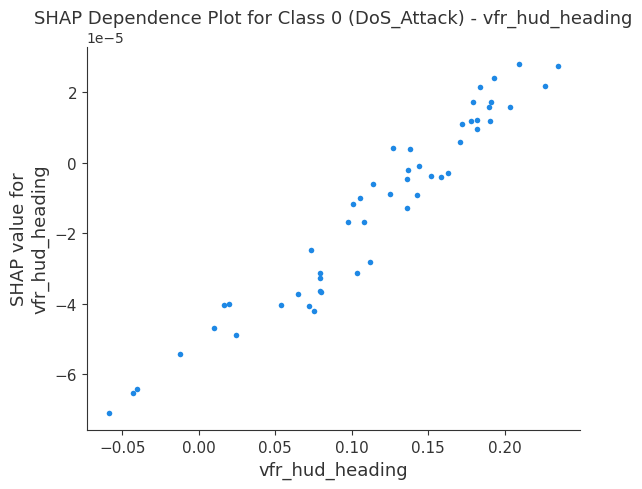

  Plotting dependence for feature: setpoint_raw-global_header.seq


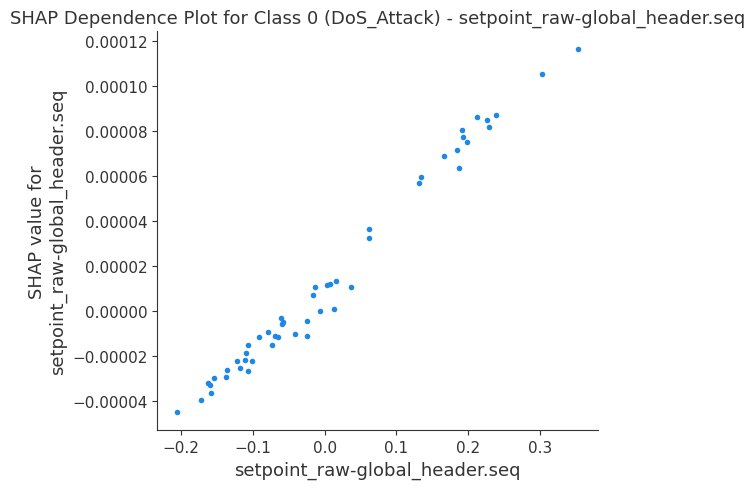

  Plotting dependence for feature: battery_header.seq


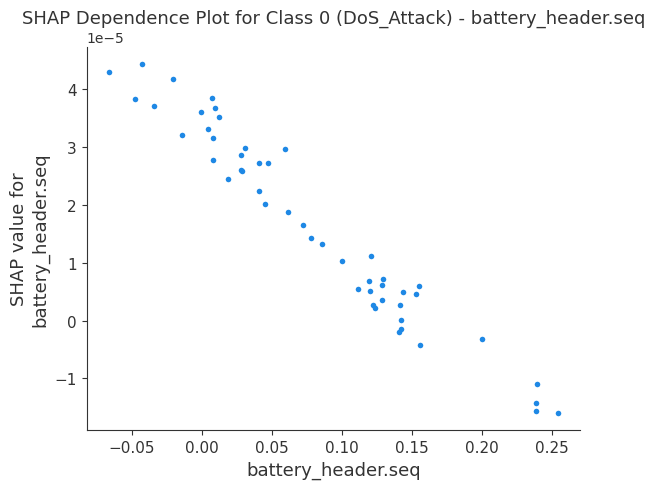

  Plotting dependence for feature: rc-out_channels_2


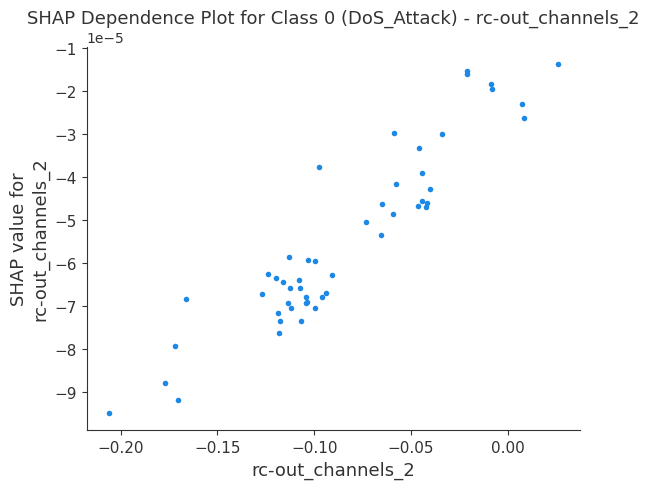

  Plotting dependence for feature: setpoint_raw-global_longitude


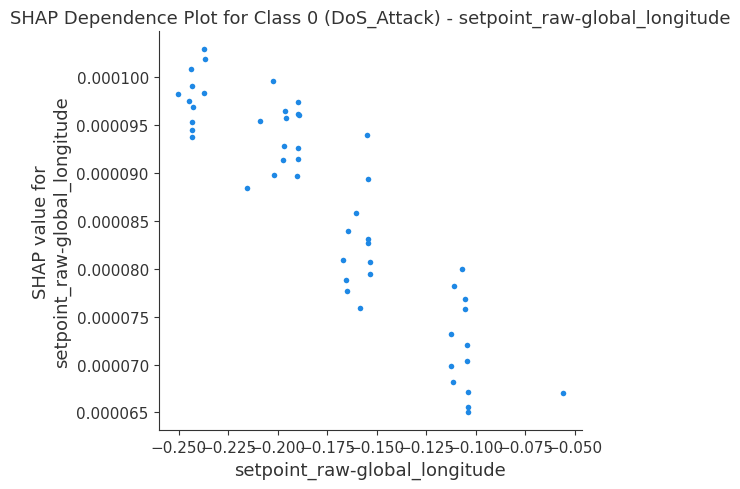


Generating dependence plots for Class 1 (Malfunction)

  Plotting dependence for feature: vfr_hud_heading


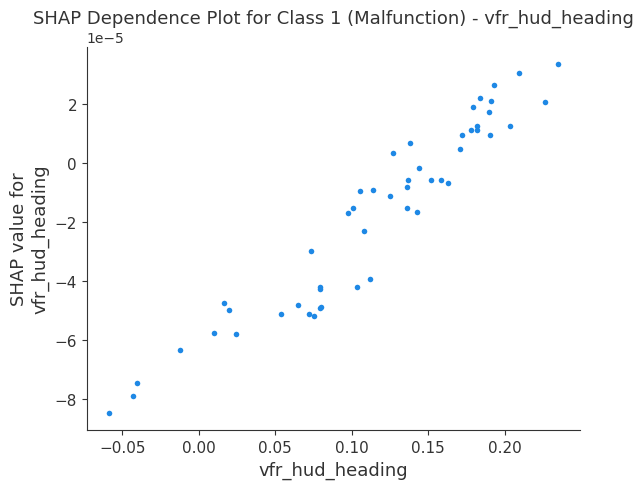

  Plotting dependence for feature: setpoint_raw-global_header.seq


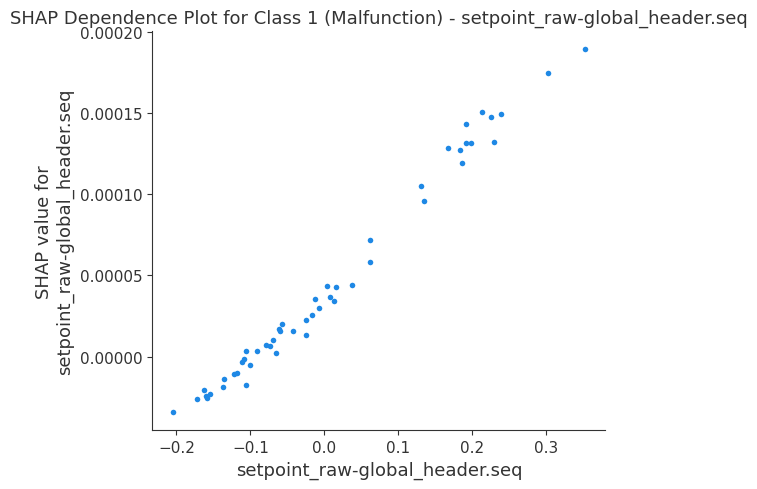

  Plotting dependence for feature: battery_header.seq


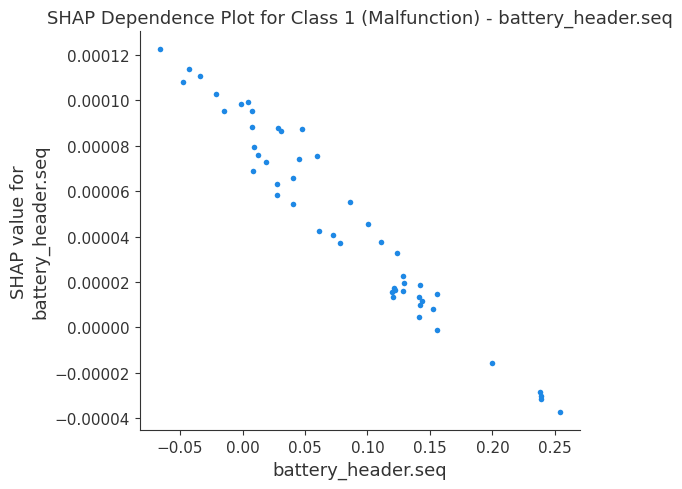

  Plotting dependence for feature: rc-out_channels_2


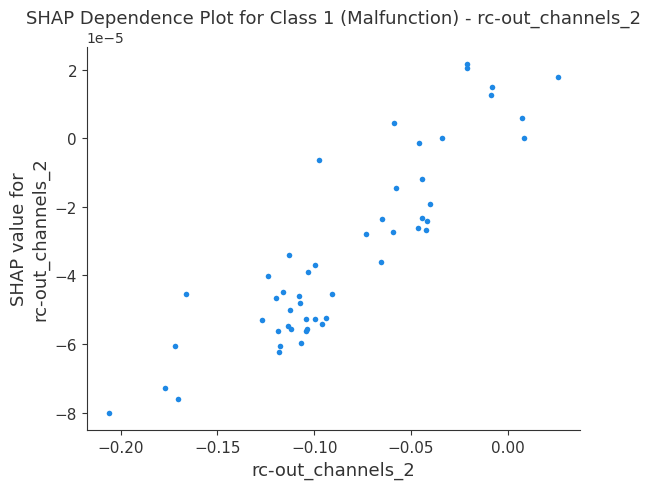

  Plotting dependence for feature: setpoint_raw-global_longitude


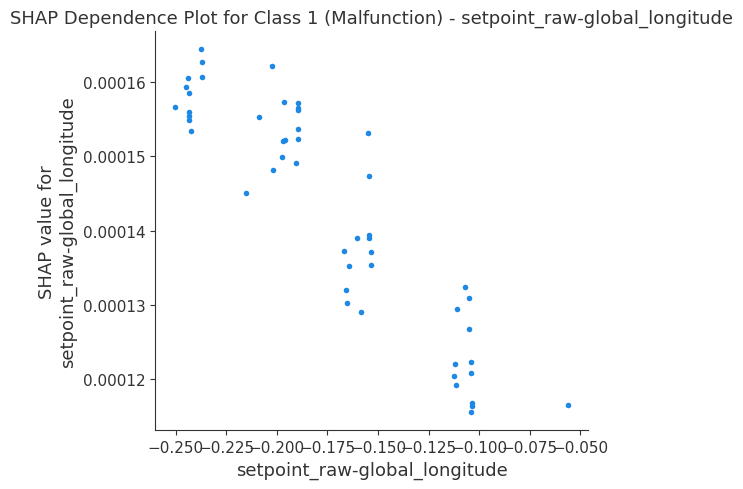


Generating dependence plots for Class 2 (Normal)

  Plotting dependence for feature: vfr_hud_heading


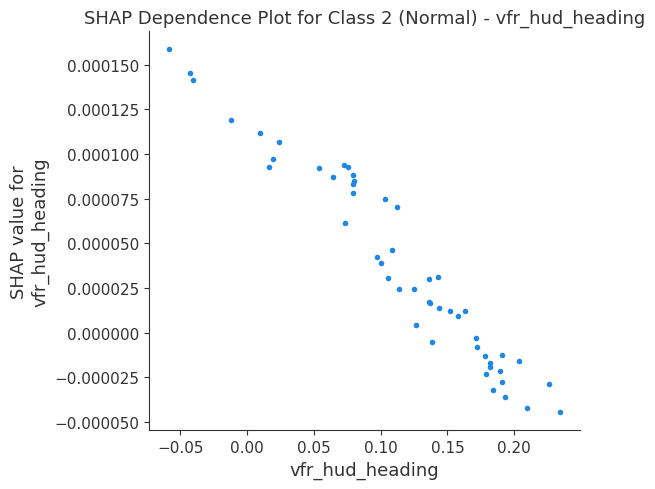

  Plotting dependence for feature: setpoint_raw-global_header.seq


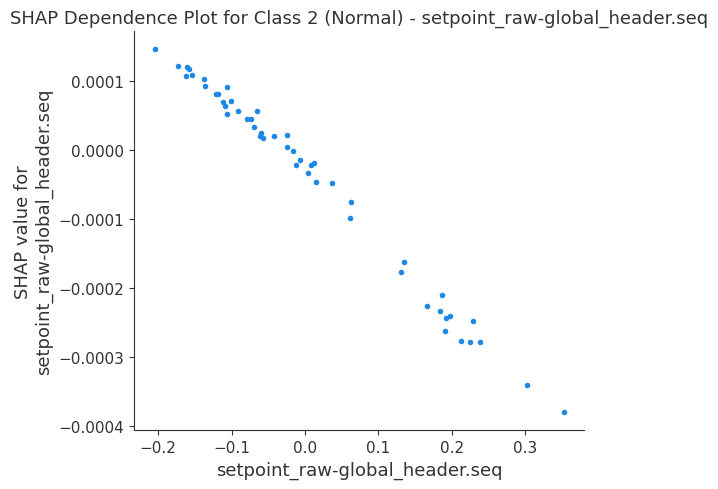

  Plotting dependence for feature: battery_header.seq


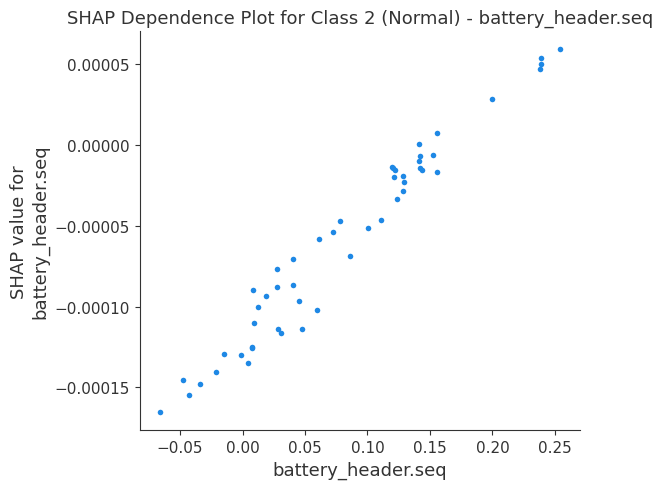

  Plotting dependence for feature: rc-out_channels_2


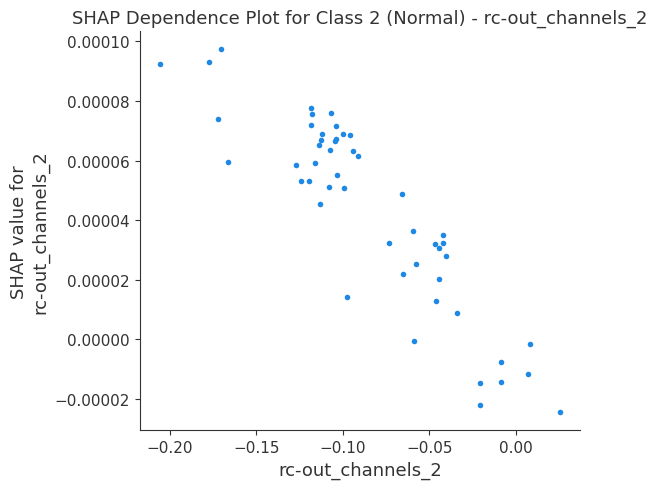

  Plotting dependence for feature: setpoint_raw-global_longitude


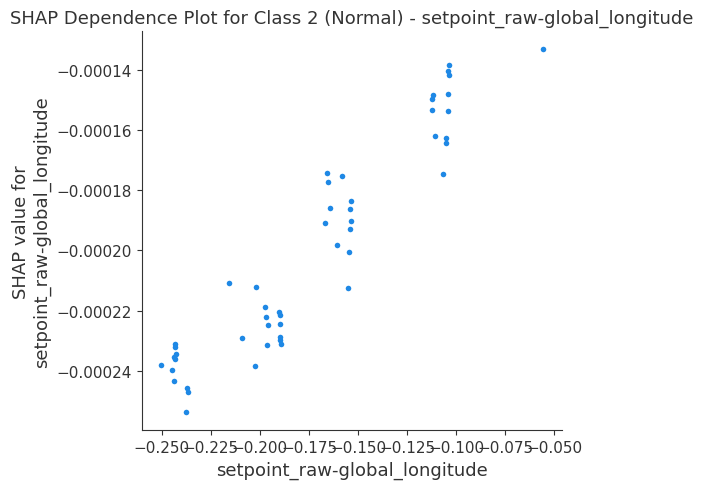

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# 1. global_feature_importance_vector
global_feature_importance_vector = np.mean(np.abs(shap_values_stacked), axis=(0, 1, 3))
print(f"Corrected shape of global_feature_importance_vector: {global_feature_importance_vector.shape}")

# 2. Convert X_shap to a NumPy array, move to CPU, and calculate X_shap_avg_time_np
X_shap_np = X_shap.cpu().numpy()
X_shap_avg_time_np = np.mean(X_shap_np, axis=1)
print(f"Shape of X_shap_avg_time_np: {X_shap_avg_time_np.shape}")

# 3. Get the indices of features sorted by their global importance in descending order
sorted_feature_indices = np.argsort(global_feature_importance_vector)[::-1]

# 4. Select the top 5 features
top_n = 5
top_feature_indices = sorted_feature_indices[:top_n]
top_feature_names = [filtered_feature_names[i] for i in top_feature_indices]

# 5. Print the names of the identified top features
print(f"\nTop {top_n} features for dependence plots: {top_feature_names}")

# 6. Loop through each class and generate dependence plots for top features
num_classes_actual = shap_values_stacked.shape[3]

for cls in range(num_classes_actual):
    print(f"\nGenerating dependence plots for Class {cls} ({class_mapping[cls]})\n")
    for feature_idx in top_feature_indices:
        feature_name = filtered_feature_names[feature_idx]
        print(f"  Plotting dependence for feature: {feature_name}")

        # Extract SHAP values for the current class (last dimension) and average over the time dimension (axis=1)
        current_class_shap_values_avg_time = np.mean(shap_values_stacked[:, :, :, cls], axis=1)

        shap.dependence_plot(
            ind=feature_idx,
            shap_values=current_class_shap_values_avg_time,
            features=X_shap_avg_time_np,
            feature_names=filtered_feature_names,
            interaction_index=None,
            title=f"SHAP Dependence Plot for Class {cls} ({class_mapping[cls]}) - {feature_name}",
            show=False
        )
        plt.tight_layout()
        plt.show()


### SHAP - Force & Waterfall Plots



Shape of time-averaged SHAP values per sample/class: (50, 74, 3)
Base values (expected_value) for each class: [-0.24759136 -0.43377188  0.522937  ]

Generating plots for the first 3 instances...

--- Instance 0 ---
  Plotting for Class 0 (DoS_Attack)
    Generating Force Plot for Instance 0, Class 0 (DoS_Attack)...


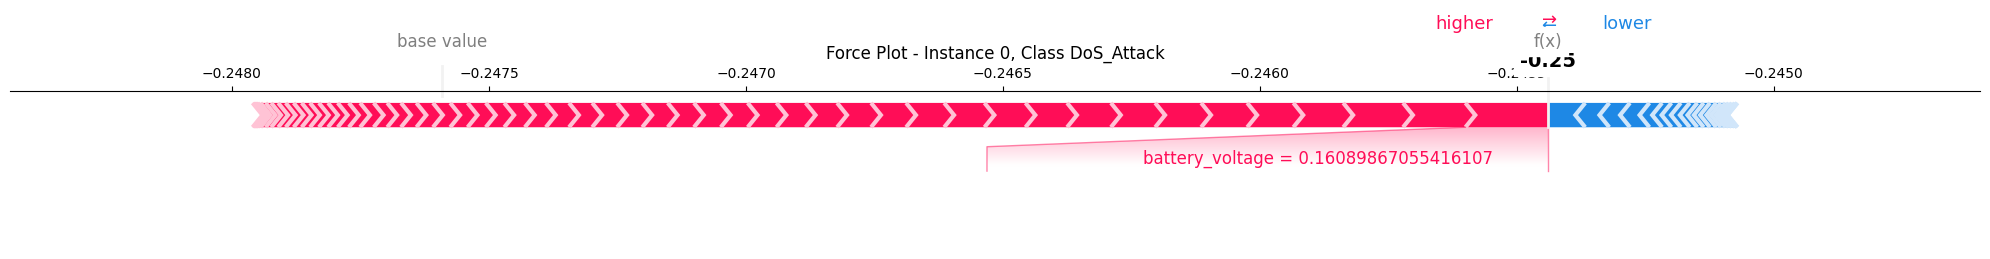

    Generating Waterfall Plot for Instance 0, Class 0 (DoS_Attack)...


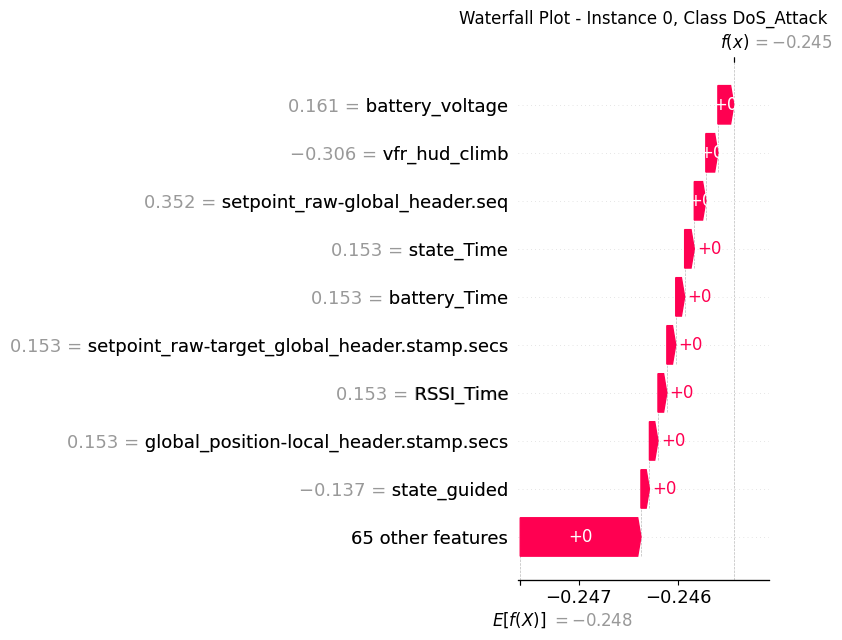

  Plotting for Class 1 (Malfunction)
    Generating Force Plot for Instance 0, Class 1 (Malfunction)...


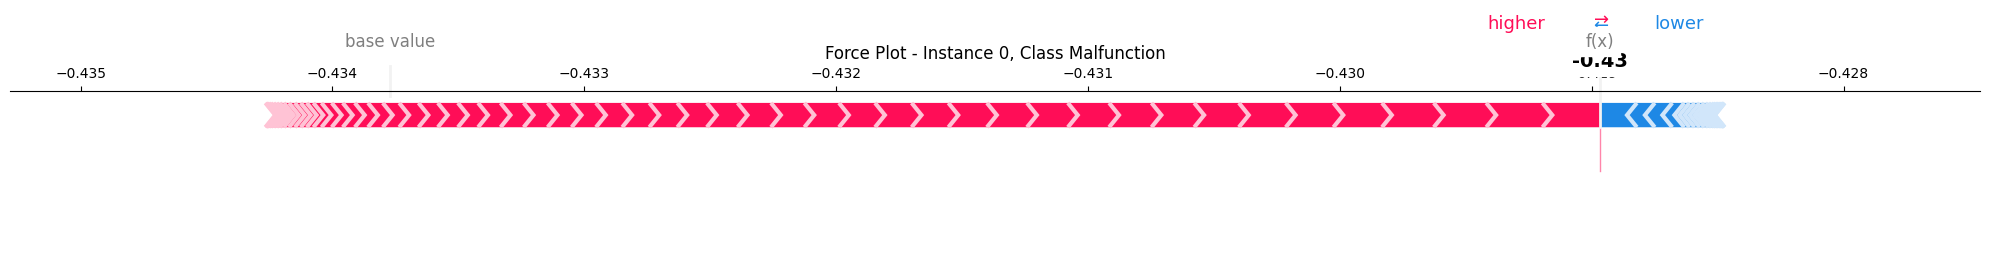

    Generating Waterfall Plot for Instance 0, Class 1 (Malfunction)...


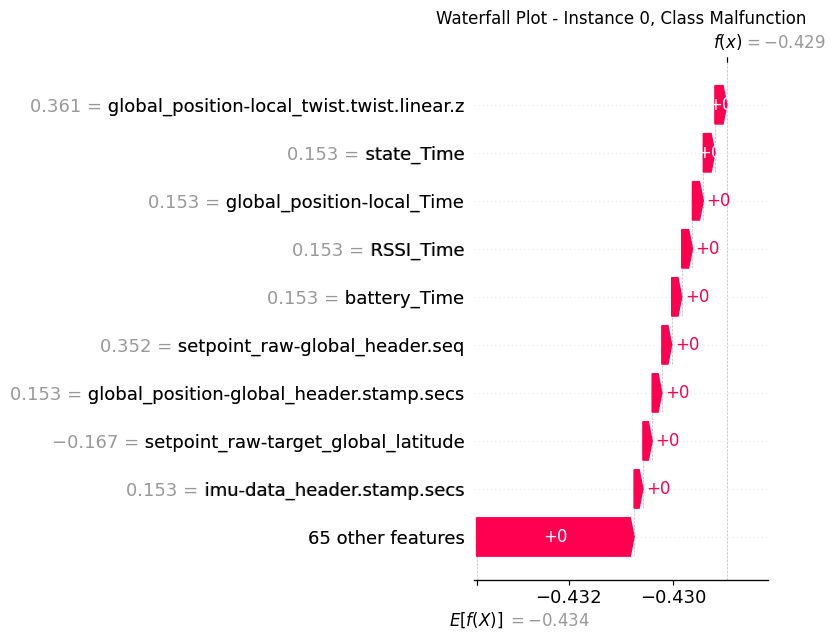

  Plotting for Class 2 (Normal)
    Generating Force Plot for Instance 0, Class 2 (Normal)...


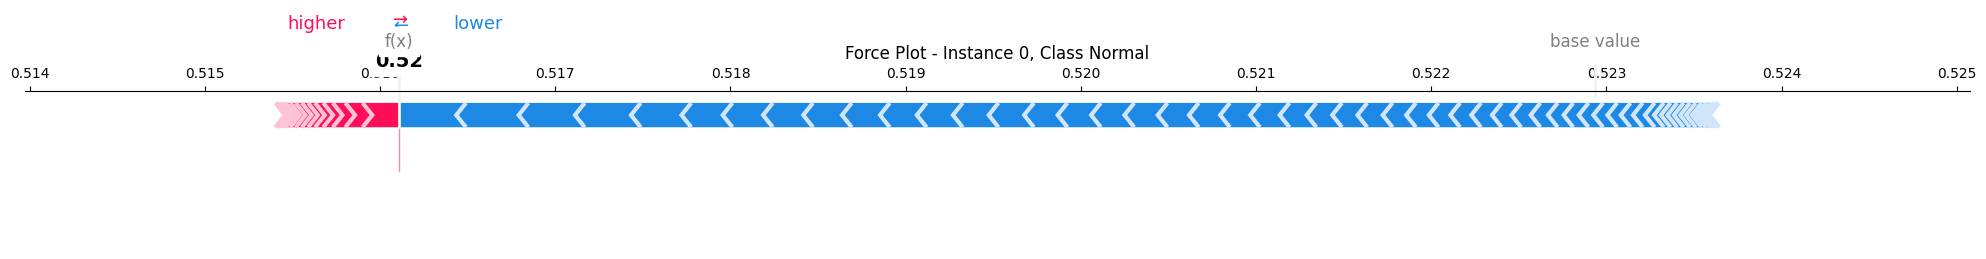

    Generating Waterfall Plot for Instance 0, Class 2 (Normal)...


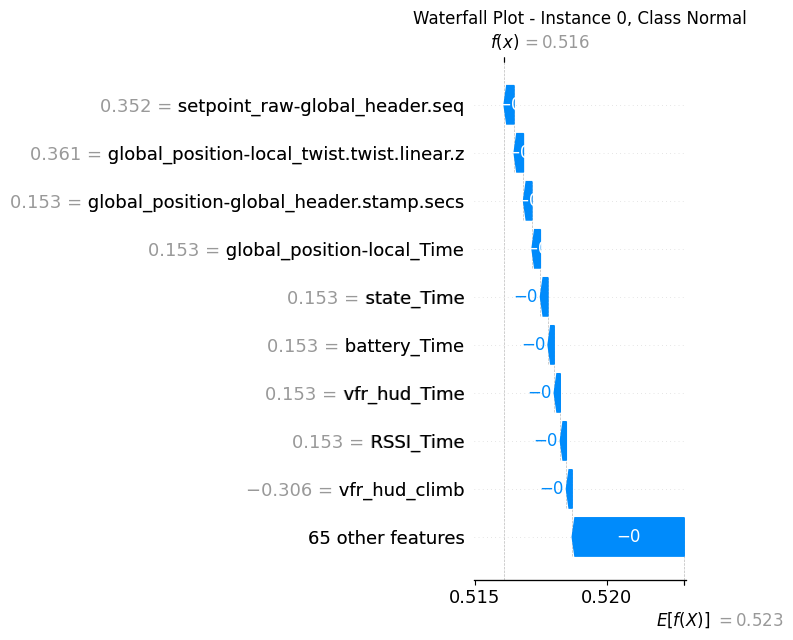


--- Instance 1 ---
  Plotting for Class 0 (DoS_Attack)
    Generating Force Plot for Instance 1, Class 0 (DoS_Attack)...


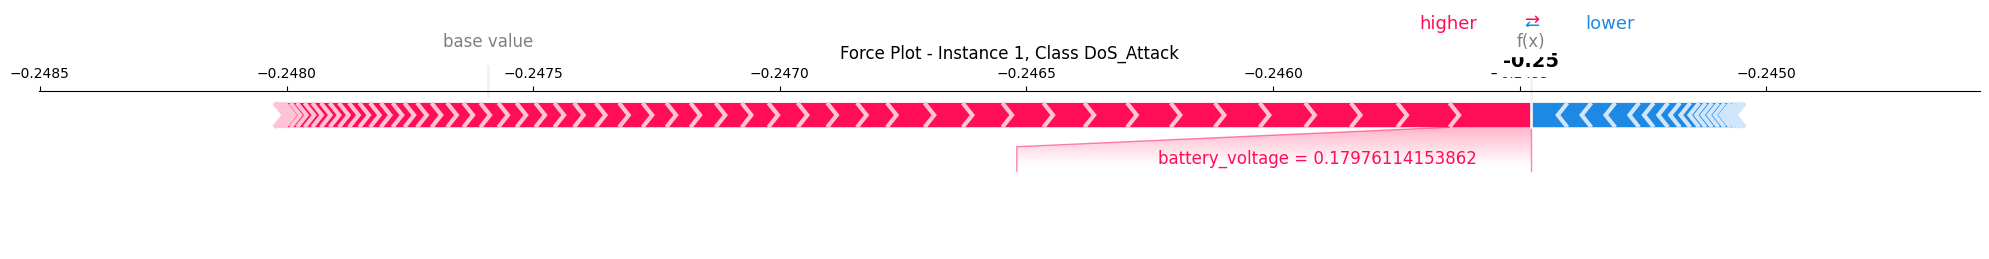

    Generating Waterfall Plot for Instance 1, Class 0 (DoS_Attack)...


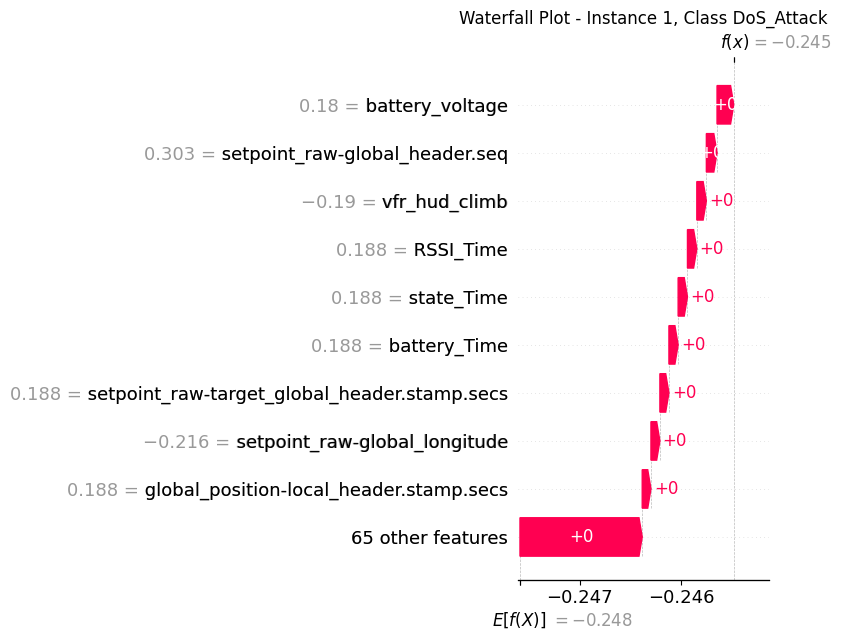

  Plotting for Class 1 (Malfunction)
    Generating Force Plot for Instance 1, Class 1 (Malfunction)...


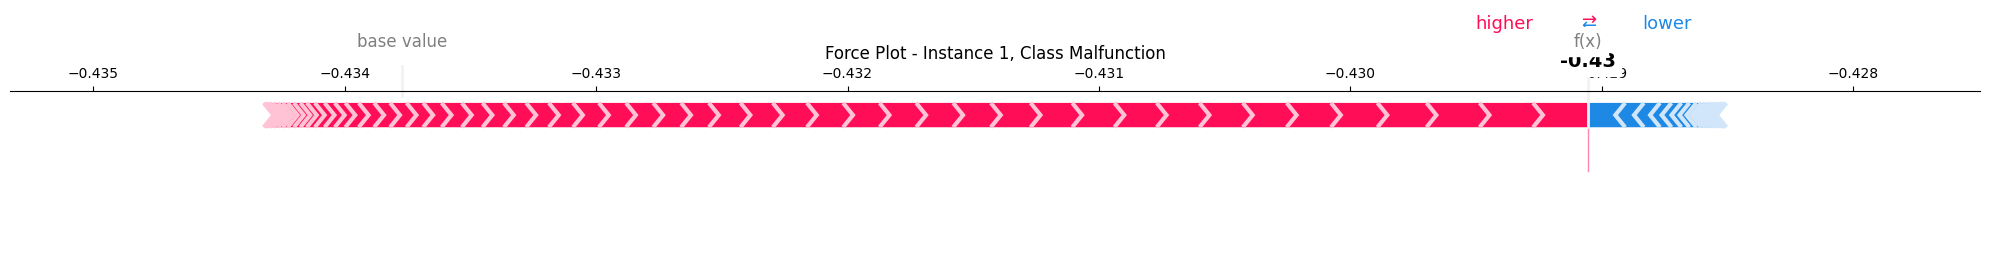

    Generating Waterfall Plot for Instance 1, Class 1 (Malfunction)...


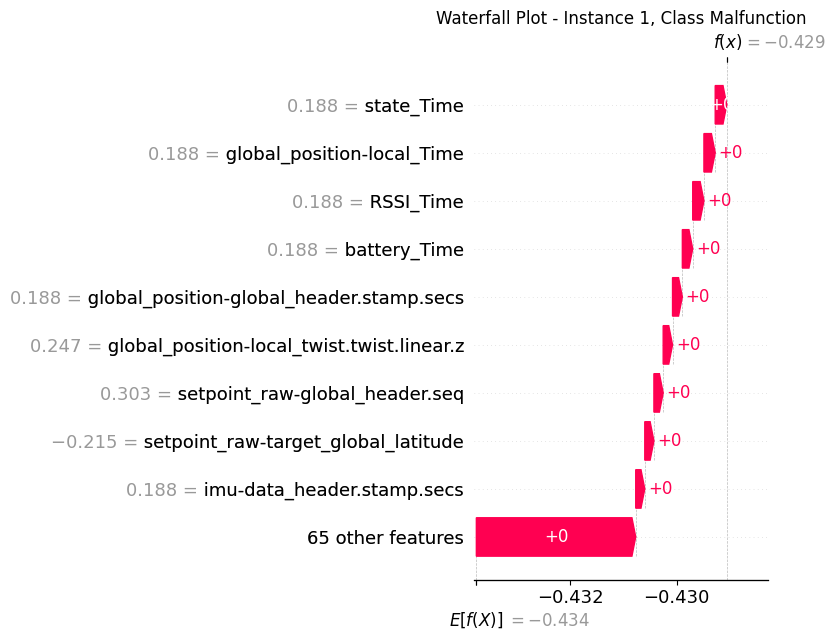

  Plotting for Class 2 (Normal)
    Generating Force Plot for Instance 1, Class 2 (Normal)...


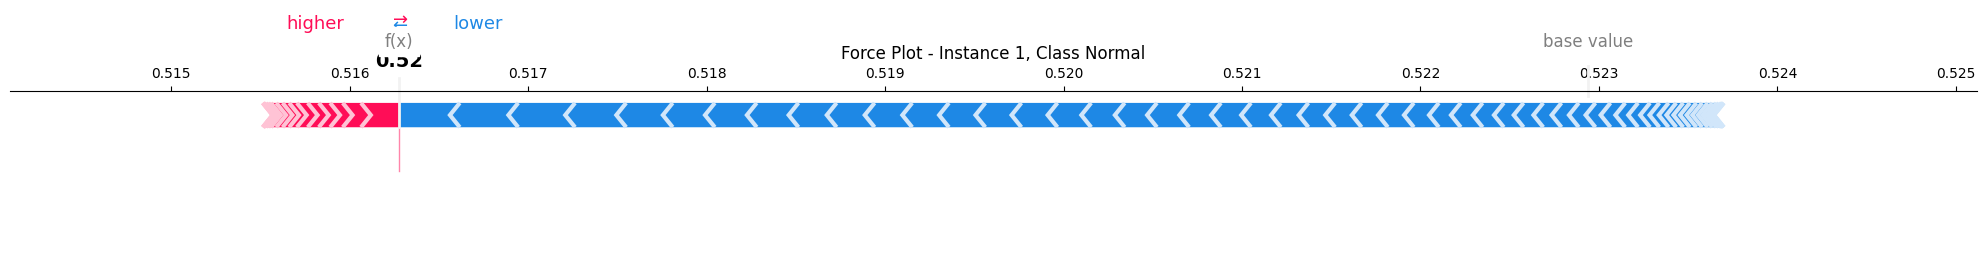

    Generating Waterfall Plot for Instance 1, Class 2 (Normal)...


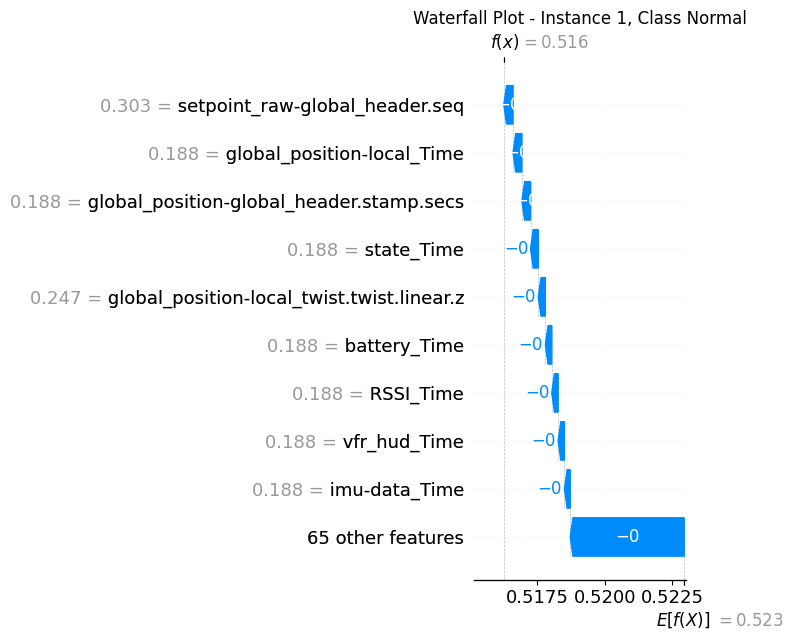


--- Instance 2 ---
  Plotting for Class 0 (DoS_Attack)
    Generating Force Plot for Instance 2, Class 0 (DoS_Attack)...


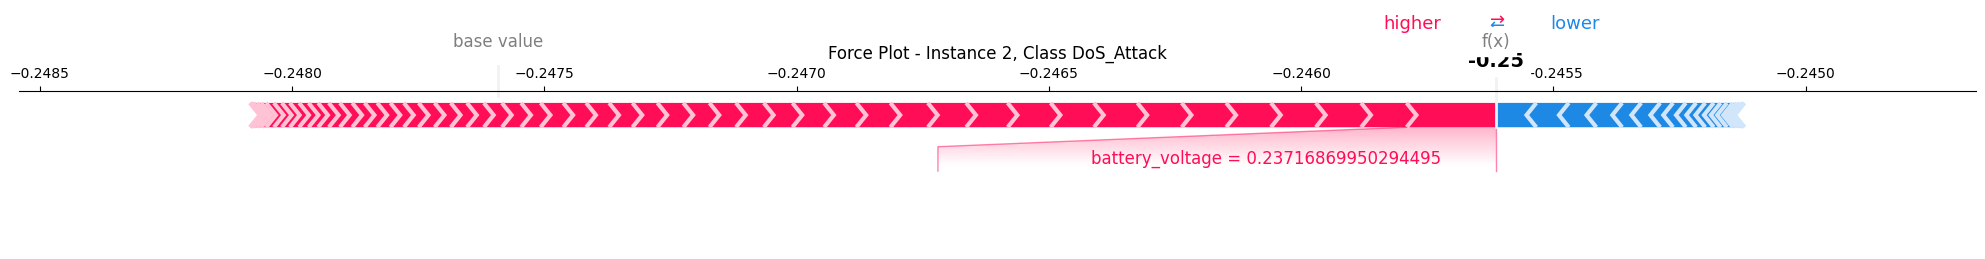

    Generating Waterfall Plot for Instance 2, Class 0 (DoS_Attack)...


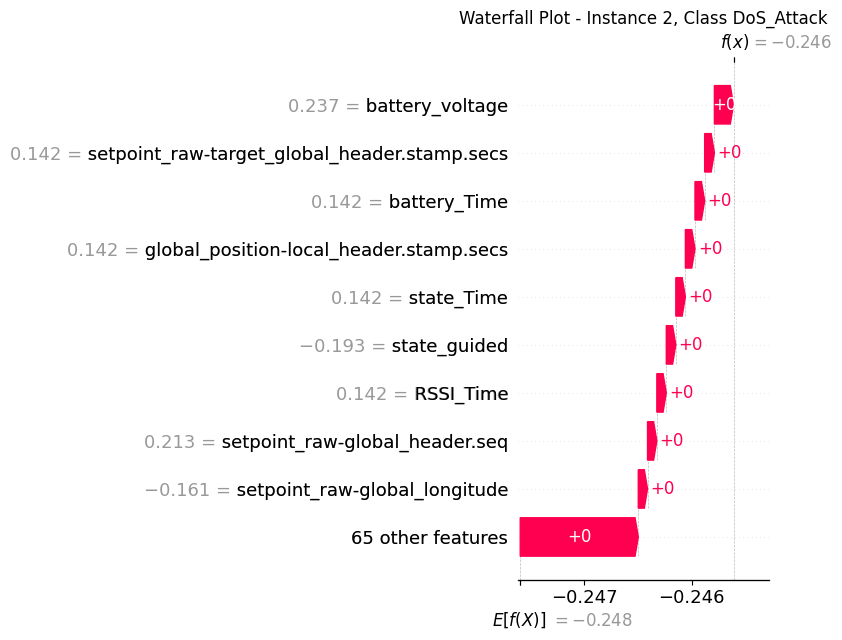

  Plotting for Class 1 (Malfunction)
    Generating Force Plot for Instance 2, Class 1 (Malfunction)...


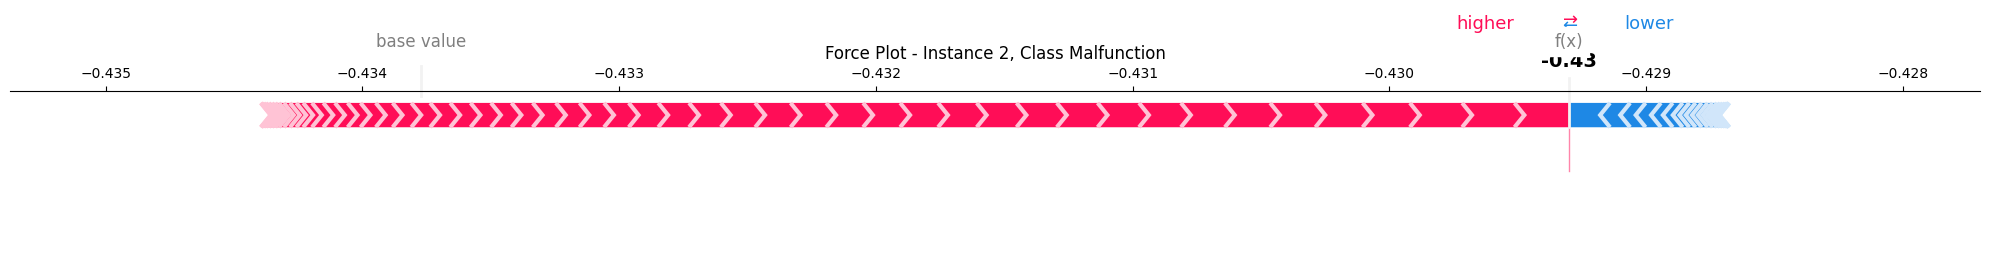

    Generating Waterfall Plot for Instance 2, Class 1 (Malfunction)...


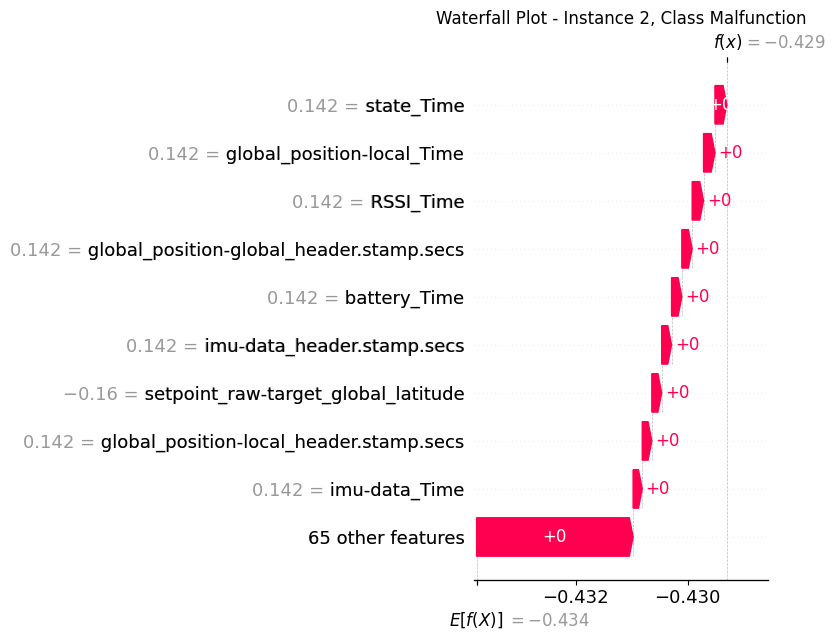

  Plotting for Class 2 (Normal)
    Generating Force Plot for Instance 2, Class 2 (Normal)...


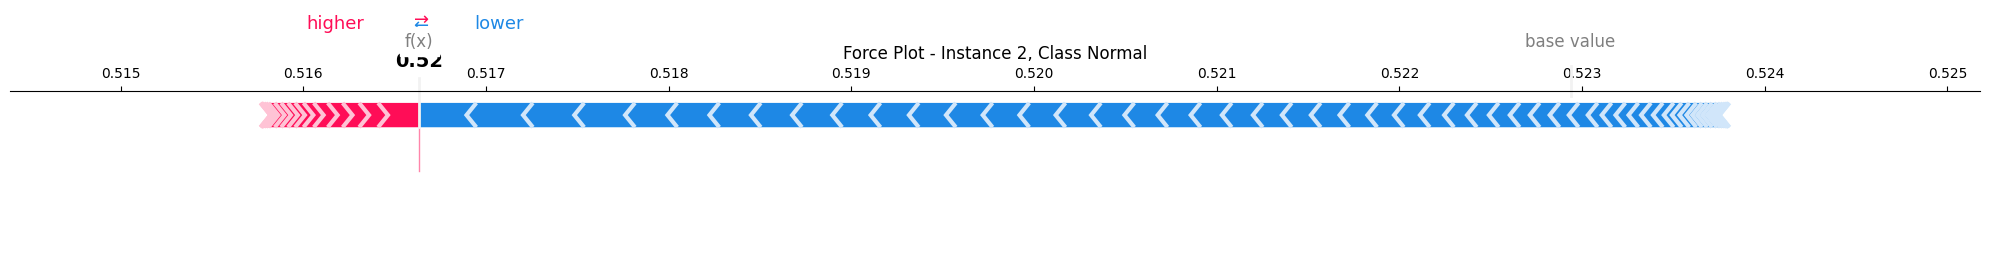

    Generating Waterfall Plot for Instance 2, Class 2 (Normal)...


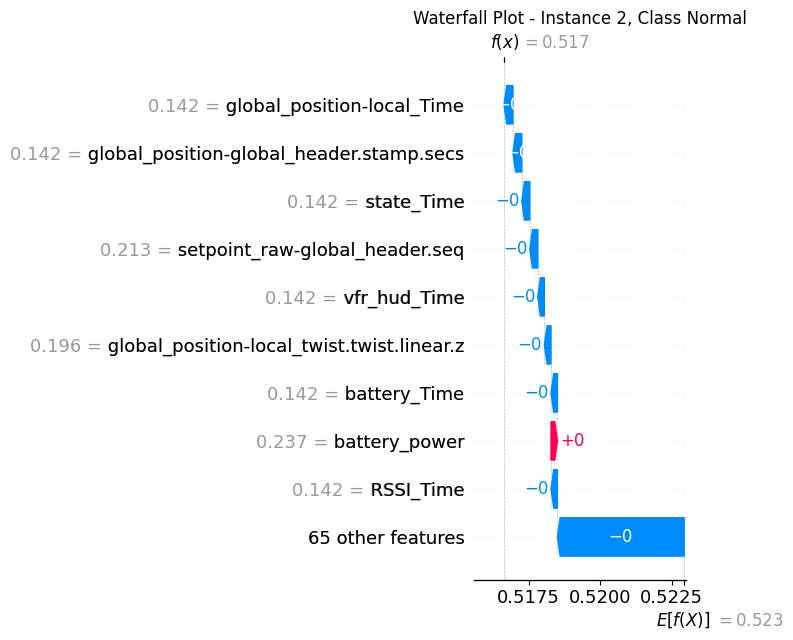


All force and waterfall plots generated.


In [132]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# 1. Calculate the time-averaged SHAP values for each sample and each class
shap_values_avg_time_per_sample_class = np.mean(shap_values_stacked, axis=1)
print(f"Shape of time-averaged SHAP values per sample/class: {shap_values_avg_time_per_sample_class.shape}")

# 2. Retrieve the base_value (expected value) from the explainer
base_values = explainer.expected_value
print(f"Base values (expected_value) for each class: {base_values}")

# 3. Select a small number of instances from X_shap for plotting
num_instances_to_plot = 3 # You can adjust this number
selected_instance_indices = range(num_instances_to_plot)
print(f"\nGenerating plots for the first {num_instances_to_plot} instances...")

# 4. Get the number of classes from the shap_values_stacked array
num_classes_actual = shap_values_stacked.shape[3]

# 5. Loop through each selected instance and then through each class
for instance_idx in selected_instance_indices:
    print(f"\n--- Instance {instance_idx} ---")
    for cls in range(num_classes_actual):
        class_name = class_mapping[cls]
        print(f"  Plotting for Class {cls} ({class_name})")

        # Extract the time-averaged SHAP values for the specific instance and class
        shap_values_for_this_plot = shap_values_avg_time_per_sample_class[instance_idx, :, cls]

        # Extract the time-averaged feature values for the specific instance
        features_for_this_plot = X_shap_avg_time_np[instance_idx, :]

        # Get the corresponding base_value for the current class
        base_value_for_this_plot = base_values[cls]

        # 6. Generate a SHAP force plot
        print(f"    Generating Force Plot for Instance {instance_idx}, Class {cls} ({class_name})...")
        shap.force_plot(
            base_value=base_value_for_this_plot,
            shap_values=shap_values_for_this_plot,
            features=features_for_this_plot,
            feature_names=filtered_feature_names,
            matplotlib=True, # Use matplotlib backend for display
            show=False
        )
        plt.title(f"Force Plot - Instance {instance_idx}, Class {class_name}")
        plt.tight_layout()
        plt.show()

        print(f"    Generating Waterfall Plot for Instance {instance_idx}, Class {cls} ({class_name})...")
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values_for_this_plot,
                base_values=base_value_for_this_plot,
                data=features_for_this_plot,
                feature_names=filtered_feature_names
            ),
            max_display=10, # Display top 10 features
            show=False
        )
        plt.title(f"Waterfall Plot - Instance {instance_idx}, Class {class_name}")
        plt.tight_layout()
        plt.show()

print("\nAll force and waterfall plots generated.")

### Partial Dependence Plots (PDP)


In [140]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPClassifier

class LSTMWrapper:
    def __init__(self, model, n_steps, device):
        self.model = model.eval() # Ensure model is in eval mode
        self.n_steps = n_steps
        self.device = device
        # Infer number of classes from model's final layer
        self.n_classes = model.fc.out_features
        self._estimator_type = "classifier"

    def fit(self, X, y=None):
        # Dummy fit method to satisfy sklearn's estimator interface
        self.classes_ = np.arange(self.n_classes) # Set classes_ attribute
        return self

    def predict_proba(self, X):
        X_sequence = np.repeat(X[:, np.newaxis, :], self.n_steps, axis=1)

        X_tensor = torch.tensor(X_sequence, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            logits = self.model(X_tensor)
            probabilities = torch.softmax(logits, dim=1)

        return probabilities.cpu().numpy()

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

model_wrapper = LSTMWrapper(model, n_steps, DEVICE)

print("LSTM Wrapper created for Partial Dependence Plots.")

LSTM Wrapper created for Partial Dependence Plots.


Generating PDPs for top 5 features: ['vfr_hud_heading', 'setpoint_raw-global_header.seq', 'battery_header.seq', 'rc-out_channels_2', 'setpoint_raw-global_longitude']

Generating Partial Dependence Plots for each class...
Plotting for Class 0 (DoS_Attack)


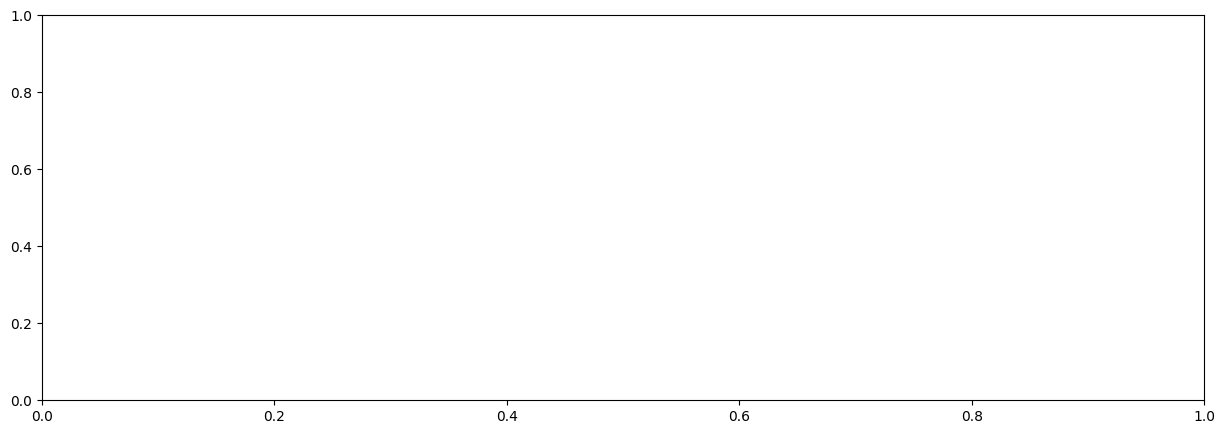

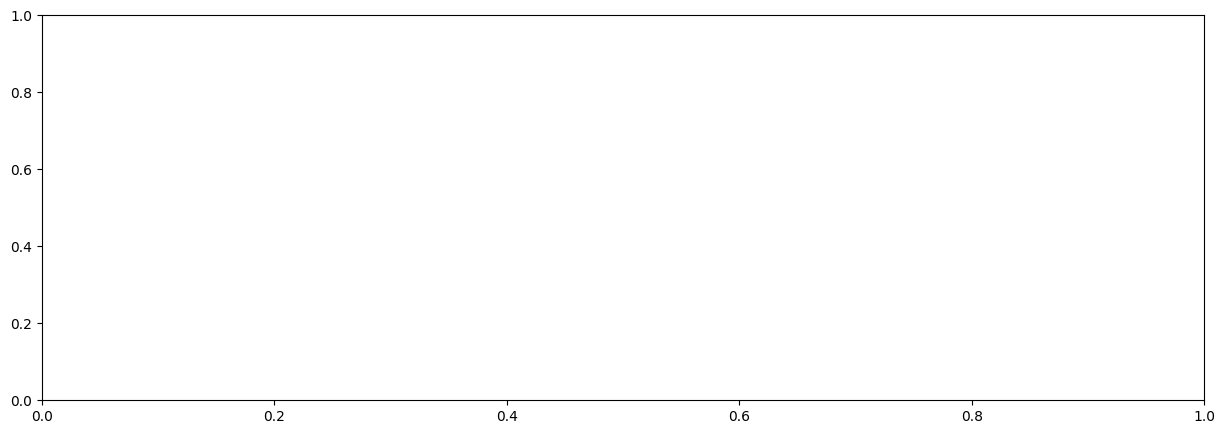

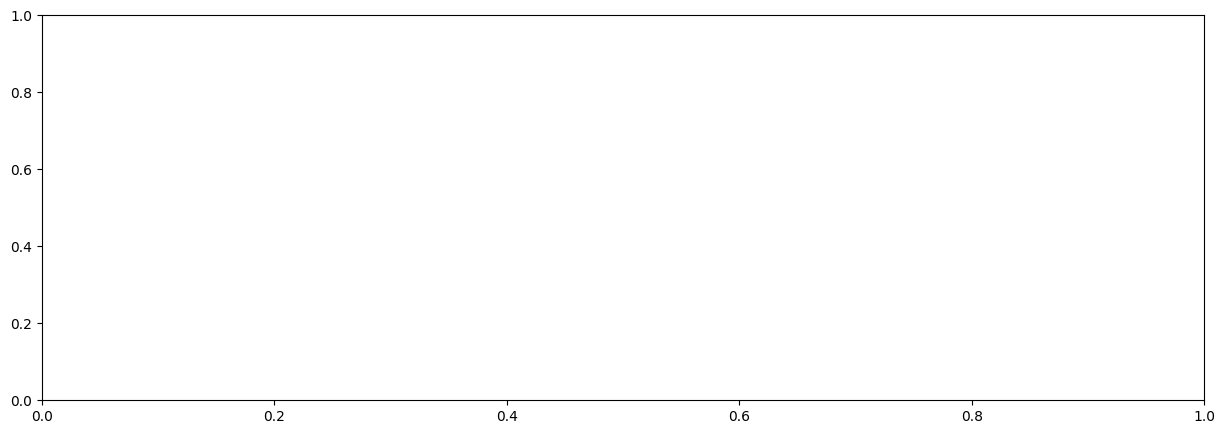

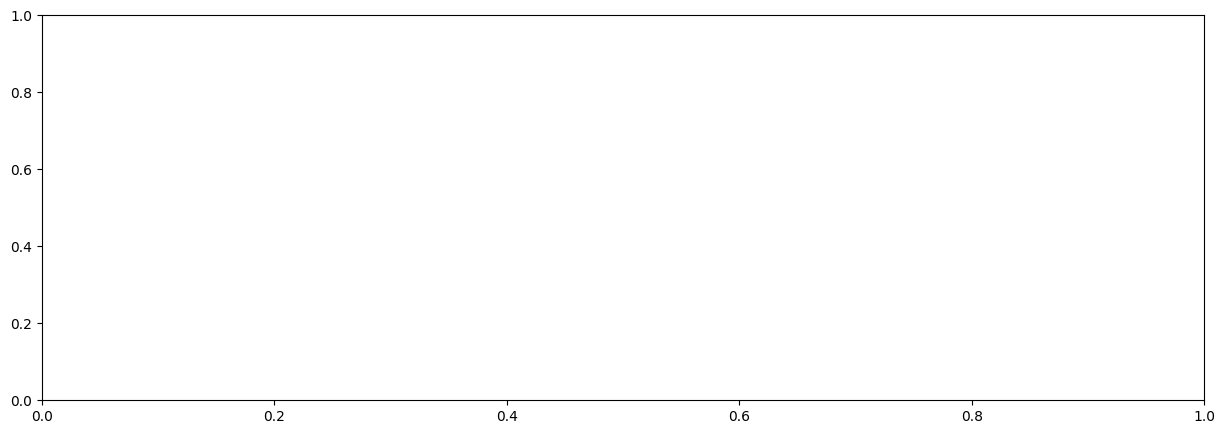

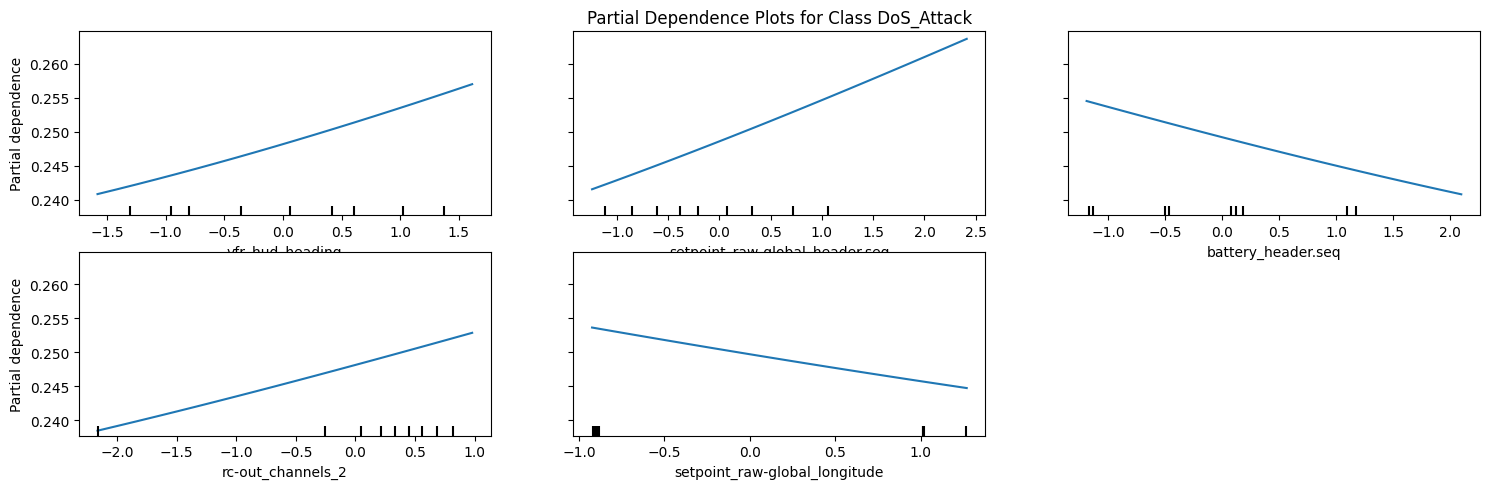

Plotting for Class 1 (Malfunction)


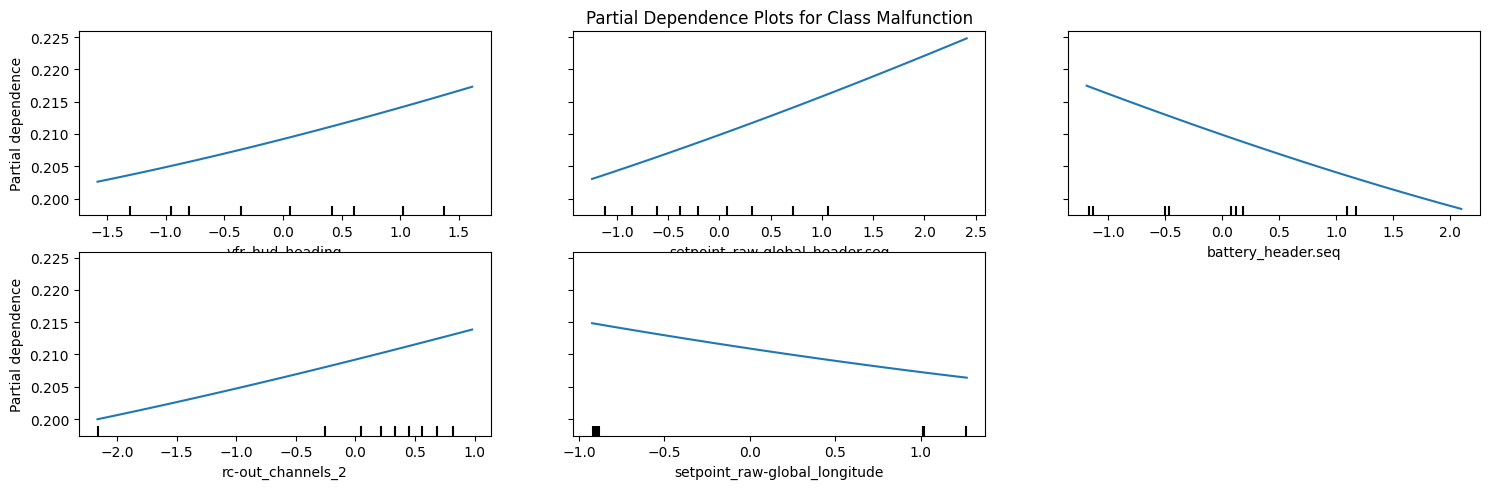

Plotting for Class 2 (Normal)


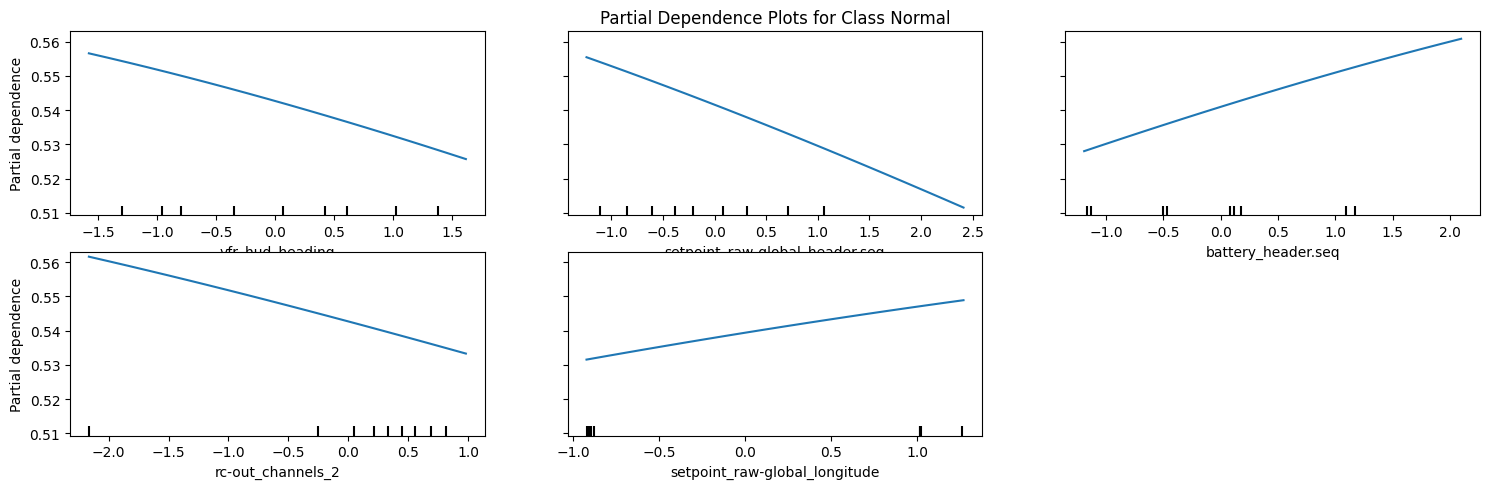

Partial Dependence Plots generation complete.


In [141]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

print(f"Generating PDPs for top 5 features: {top_feature_names}")

# Ensure X_train_scaled is a numpy array for sklearn functions
if not isinstance(X_train_scaled, np.ndarray):
    X_train_scaled = np.array(X_train_scaled)

model_wrapper.fit(X_train_scaled)

# Create a list of feature indices to plot
features_to_plot_indices = top_feature_indices.tolist()

# Generate PDPs for each class
print("\nGenerating Partial Dependence Plots for each class...")
for i, class_label in class_mapping.items():
    print(f"Plotting for Class {i} ({class_label})")

    # Use the LSTMWrapper with predict_proba for PDPs
    # The target parameter for plot_partial_dependence refers to the class index
    fig, ax = plt.subplots(figsize=(15, 5))
    PartialDependenceDisplay.from_estimator(
        estimator=model_wrapper,
        X=X_train_scaled,
        features=features_to_plot_indices,
        feature_names=filtered_feature_names,
        target=i, # Plot PDP for the current class
        grid_resolution=20,
        ax=ax
    )
    ax.set_title(f"Partial Dependence Plots for Class {class_label}")
    plt.tight_layout()
    plt.show()

print("Partial Dependence Plots generation complete.")


### Conclusion

**Insights into Feature-Prediction Relationships:**
*   **Non-linear Relationships:** PDPs often reveal non-linear relationships between feature values and the model's output. For instance, the probability of a 'Malfunction' might increase sharply after a certain threshold value for `battery_header.seq` (indicating battery issues), but remain relatively flat below that threshold.
*   **Class-Specific Contributions:** SHAP dependence plots clearly show that the impact direction (positive or negative SHAP value) and magnitude of a feature can vary significantly across different classes for the same feature value range. A feature value that increases the likelihood of a 'DoS_Attack' might simultaneously decrease the likelihood of a 'Normal' state.
*   **Individual Prediction Explanations:** Force and waterfall plots highlight which specific features, with their actual values in a given instance, were most critical in determining that particular prediction. This helps to understand why the model classified an instance as 'DoS_Attack' (e.g., strong positive contribution from `rc-out_channels_2` and negative from `setpoint_raw-global_longitude`).
*   **Time-Averaged Influence:** By averaging SHAP values and features over the time dimension, the analysis provides insights into the overall, sustained influence of features on the model's predictions over a sequence, rather than instantaneous effects. This is crucial for time-series data where the history of features matters.

*   The top 5 most globally important features identified through SHAP analysis are `vfr_hud_heading`, `setpoint_raw-global_header.seq`, `battery_header.seq`, `rc-out_channels_2`, and `setpoint_raw-global_longitude`.
*   The `global_feature_importance_vector` was initially miscalculated, leading to incorrect top feature identification, but was corrected to accurately represent feature importance across samples, time steps, and classes, yielding a vector of shape `(74,)`.
*   SHAP dependence plots were successfully generated for the top 5 features across all 3 classes, illustrating the relationship between feature values and their SHAP contributions.
*   SHAP force and waterfall plots were successfully generated for 3 selected instances across all 3 classes (total of 18 plots), providing instance-specific explanations of model predictions.
*   The `explainer.expected_value` (base values) for the three classes were identified as approximately `[-0.248, -0.434, 0.523]`.
*   An `LSTMWrapper` class was successfully developed to enable the LSTM model's compatibility with `sklearn.inspection.PartialDependenceDisplay` by transforming 2D feature inputs into the 3D sequence format expected by the LSTM.
*   Partial Dependence Plots were generated for the top 5 features for each of the 3 classes, visually depicting the marginal effect of feature values on predicted class probabilities.

